# House Price Prediction: Advanced Regression Assignment

### Problem Statement:

A US-based housing company named Surprise Housing has decided to enter the Australian market. The company uses data analytics to purchase houses at a price below their actual values and flip them on at a higher price. For the same purpose, the company has collected a data set from the sale of houses in Australia. The company is looking at prospective properties to buy to enter the market. We are required to build a regression model using regularisation in order to predict the actual value of the prospective properties and decide whether to invest in them or not.


Essentially, the company wants to know —

- Which variables are significant in predicting the price of a house, and

- How well those variables describe the price of a house.

Also, determine the optimal value of lambda for ridge and lasso regression.

## Step 1: Reading and Understanding the Data

In [1]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# import baseline packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

# import libraries for regression
from sklearn.metrics import r2_score
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

%matplotlib inline
sns.set()

In [3]:
# Read assignment data train.csv dataset into a dataframe
saleprice_df = pd.read_csv('train.csv')
print(saleprice_df.shape)
saleprice_df.head()

(1460, 81)


Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD         Normal     208500  
1   2007        WD         Normal     181500  
2   2008        WD         Normal     223500  
3   2006        WD        Abnorml     140000  
4   2008        WD         Normal     250000  

[5 rows x 81 columns]

### Helper Methods

In [4]:
# Method to get basic details about the dataset.
# <parameter> df - Pass the dataframe
# <return> Print the basic details such as shape, size, columns, data type etc.
def get_basic_details(df):
    print("Shape of dataset")
    print(df.shape)
    print("\nNumber of Observations in dataset")
    print(df.size)
    print("\nBasic Info")
    print(df.info())
    print("\nColumn names")
    print(df.columns)
    print("\ndata types frequency")
    print(df.dtypes.value_counts())
    print("\nTop 3 Columns having largest number of missing values")
    print(df.isnull().sum().nlargest(3))
    print("\nTop 3 Rows having largest number of missing values")
    print(df.isnull().sum(axis=1).nlargest(3))
    print("\nNumber of total missing data in dataframe")
    print(df.isnull().sum().sum())

In [5]:
# Compute the missing value count and misisng % for each variables.
# <parameter> df - Pass the dataframe.
# <returns> return the missing values & % of misisng values for all the columns in the dataframe.
def missing_values_table_columnwise(df):
        # Get Total missing values
        mis_val = df.isnull().sum()
        
        if(mis_val.sum() == 0):
            return 'All good, no missing data found in any column.'
        if(mis_val.all()):
            return 'There are no observations at all.'
        
        # Calculate Percentage of missing values
        mis_val_percent = round(100 * df.isnull().sum() / len(df.index),2)
        
        # Create a table with the results from mis_val and mis_val_percent
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table = mis_val_table.rename(
        columns = {0 : 'missing_val_count', 1 : 'percent'})
        
       # Sort the table by percentage of missing descending
        mis_val_table = mis_val_table[
            mis_val_table.iloc[:,1] != 0].sort_values(
        'percent', ascending=False)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table.shape[0]) +
              " columns that have missing values.")
                
        # Return the dataframe with missing information
        return mis_val_table

In [6]:
# This function will return the list of columns having misisng value % greater than or equal to thresh limit
# Param1 :- df - pass the dataframe
# Param2 :- thresh - Pass the misisng value % limit
# param3 :- drop - Pass True if want to drop the columns which have more misisng value % than thresh, default False
def get_drop_columns_with_excessive_missing_value_percent(df, thresh, drop=False):
    print('Shape of dataframe columns{0}'.format(df.shape))

    # don't change passed dataframe
    df_new = df.copy()
    misisng_columns=[]
    columns_with_nan = df_new.columns[df_new.isnull().any()]
    for column in columns_with_nan:
        if 100 * df_new[column].isnull().sum() / len(df_new.index) >= thresh:
            misisng_columns.append(column)
            if drop == True:
                df_new.drop(column,1, inplace=True)
    if drop == True:
        print('Dropped {0} columns'.format(len(misisng_columns)))
        print('Shape of dataframe after droping columns{0}'.format(df_new.shape))
        return df_new
    else:
        return misisng_columns

In [7]:
# This method will get or drop the columns which have only 1 unique values in it, i.e values in all rows are same
# Takes a dataframe as input and a paramter "drop" which should be True if need to drop such column, default is False
# Returns modified dataframe if drop is True else return column list
def get_drop_column_having_one_unique_value(df, drop=False):
    print('Shape of dataframe {0}'.format(df.shape))
    
    # don't modify passed dataframe
    df_new = df.copy() 
    col_with_signle_unique_val_mask = df_new.columns[df_new.nunique() == 1]
    
    # Print some summary information
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"
           "There are " + str(len(col_with_signle_unique_val_mask)) + " columns that have only ONE distinct value in all the rows.")

    if drop==True:
        df_new.drop(col_with_signle_unique_val_mask.values,1,inplace=True)
        print('Shape of dataframe after dropping columns.{0}'.format(df_new.shape))
        return df_new 
    else:
        return df_new.loc[:,col_with_signle_unique_val_mask.values]

In [8]:
# This custom function helps to get countplot, or boxplot etc and configures plot attributes parameters
# This allows uniformity of design as well as reduce the repetition of similar code
# Default plot type is box plot and takes the target variable "price" by default.
def make_plot(all_cols=None,
              df=None,
              plot='count',
              y_col='SalePrice',
              size=(20,7),
              plt_rows=3,
              plt_cols=4):
    if plot=='box':
        for col in all_cols:
            plt.figure(figsize=size)
            sns.boxplot(x=col,y=y_col,data=saleprice_df)
    elif plot=='count':
        plt.figure(figsize=(30,90))
        i = 0
        for col in all_cols:
            plt.subplot(13,2,i+1)
            sns.countplot(x = col, data = saleprice_df)
            i+=1
        plt.show()
    elif plot=='dist':
        plt.figure(figsize=(20,17))
        features = list(df.columns)
        for col in features:
            plt.subplot(plt_rows, plt_cols, features.index(col)+1)
            sns.distplot(df[col],hist=True,kde=True,rug=False,bins=30)

### General Observations

In [9]:
# statistical info on saleprice_df dataframe
# It has total 1460 rows and 81 columns with a mix of datatypes
# We can observe that there exist columns with missing values also
saleprice_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [10]:
# statistically describe saleprice_df dataframe
# It provides many stat figures like mean, median etc. for all the quantitative columns of the dataframe
# For ex. we can observe that target variable "SalePrice" has mean of 180921.19 and median of 163000.0
saleprice_df.describe()

Id   MSSubClass  LotFrontage        LotArea  OverallQual  \
count  1460.000000  1460.000000  1201.000000    1460.000000  1460.000000   
mean    730.500000    56.897260    70.049958   10516.828082     6.099315   
std     421.610009    42.300571    24.284752    9981.264932     1.382997   
min       1.000000    20.000000    21.000000    1300.000000     1.000000   
25%     365.750000    20.000000    59.000000    7553.500000     5.000000   
50%     730.500000    50.000000    69.000000    9478.500000     6.000000   
75%    1095.250000    70.000000    80.000000   11601.500000     7.000000   
max    1460.000000   190.000000   313.000000  215245.000000    10.000000   

       OverallCond    YearBuilt  YearRemodAdd   MasVnrArea   BsmtFinSF1  ...  \
count  1460.000000  1460.000000   1460.000000  1452.000000  1460.000000  ...   
mean      5.575342  1971.267808   1984.865753   103.685262   443.639726  ...   
std       1.112799    30.202904     20.645407   181.066207   456.098091  ...   
min       1.000000  1872.000000   1950.000000     0.000000     0.000000  ...   
25%       5.000000  1954.000000   1967.000000     0.000000     0.000000  ...   
50%       5.000000  1973.000000   1994.000000     0.000000   383.500000  ...   
75%       6.000000  2000.000000   2004.000000   166.000000   712.250000  ...   
max       9.000000  2010.000000   2010.000000  1600.000000  5644.000000  ...   

        WoodDeckSF  OpenPorchSF  EnclosedPorch    3SsnPorch  ScreenPorch  \
count  1460.000000  1460.000000    1460.000000  1460.000000  1460.000000   
mean     94.244521    46.660274      21.954110     3.409589    15.060959   
std     125.338794    66.256028      61.119149    29.317331    55.757415   
min       0.000000     0.000000       0.000000     0.000000     0.000000   
25%       0.000000     0.000000       0.000000     0.000000     0.000000   
50%       0.000000    25.000000       0.000000     0.000000     0.000000   
75%     168.000000    68.000000       0.000000     0.000000     0.000000   
max     857.000000   547.000000     552.000000   508.000000   480.000000   

          PoolArea       MiscVal       MoSold       YrSold      SalePrice  
count  1460.000000   1460.000000  1460.000000  1460.000000    1460.000000  
mean      2.758904     43.489041     6.321918  2007.815753  180921.195890  
std      40.177307    496.123024     2.703626     1.328095   79442.502883  
min       0.000000      0.000000     1.000000  2006.000000   34900.000000  
25%       0.000000      0.000000     5.000000  2007.000000  129975.000000  
50%       0.000000      0.000000     6.000000  2008.000000  163000.000000  
75%       0.000000      0.000000     8.000000  2009.000000  214000.000000  
max     738.000000  15500.000000    12.000000  2010.000000  755000.000000  

[8 rows x 38 columns]

In [11]:
# We have 1460 rows and 81 columns
# There are total 118260 misisng data in loan dataset
get_basic_details(saleprice_df)

Shape of dataset
(1460, 81)

Number of Observations in dataset
118260

Basic Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460

## Step 2: Data Understanding and Cleaning
#### Approach 1 (In this approach we will cleanup the data, in next approach we'll refrain from dropping columns)
Analysing some data attributes and performing additional cleanup.

In [12]:
# Let's first drop duplicates, if any
# No duplicate rows found. shape of the dataframe remains the same
print('before shape:', saleprice_df.shape)
saleprice_df = saleprice_df.drop_duplicates()
print('after shape:', saleprice_df.shape)

before shape: (1460, 81)
after shape: (1460, 81)


In [13]:
# Also getting rid of car_ID as it seems to be just a serial number.
# There are 1460 unique values in the same number of rows for this column, so can't extract any pattern for modelling
print("Unique values in Id column:", saleprice_df['Id'].nunique())
saleprice_df.drop(['Id'], axis =1, inplace = True)
print("Id column dropped from saleprice_df")

Unique values in Id column: 1460
Id column dropped from saleprice_df


In [14]:
# Get the missing values count and percent per column using missing_values_table_columnwise() user defined function
# We can observe that there are few number of columns which have very few observations i.e >80% mising values
# Such columns which have very less data or have very high misisng value % are of no use and will create noise
# So it's better to remove such columns
missing_values_df = missing_values_table_columnwise(saleprice_df)
missing_values_df.head(10)

Your selected dataframe has 80 columns.
There are 19 columns that have missing values.


missing_val_count  percent
PoolQC                     1453    99.52
MiscFeature                1406    96.30
Alley                      1369    93.77
Fence                      1179    80.75
FireplaceQu                 690    47.26
LotFrontage                 259    17.74
GarageType                   81     5.55
GarageYrBlt                  81     5.55
GarageFinish                 81     5.55
GarageQual                   81     5.55

In [15]:
# Call drop_columns_with_excessive_missing_value_percent() method passing dataframe,
# thresh and drop=True as we want to drop such columns
# thresh=80 will drop those columns which have more than 80% of misisng values in it
# So we dropped 4 columns having more than 80% missing value percentage
saleprice_df = get_drop_columns_with_excessive_missing_value_percent(saleprice_df,80,True)

Shape of dataframe columns(1460, 80)
Dropped 4 columns
Shape of dataframe after droping columns(1460, 76)


In [16]:
# Again analyze reduced saleprice_df using missing_values_table_columnwise utility
# Now we observe that except one column having missing percentage as 47%, all other 14 columns have low missing values
# so to cleanup data further we would like to understand each column better with data understanding
missing_values_table_columnwise(saleprice_df)

Your selected dataframe has 76 columns.
There are 15 columns that have missing values.


missing_val_count  percent
FireplaceQu                 690    47.26
LotFrontage                 259    17.74
GarageType                   81     5.55
GarageYrBlt                  81     5.55
GarageFinish                 81     5.55
GarageQual                   81     5.55
GarageCond                   81     5.55
BsmtExposure                 38     2.60
BsmtFinType2                 38     2.60
BsmtQual                     37     2.53
BsmtCond                     37     2.53
BsmtFinType1                 37     2.53
MasVnrType                    8     0.55
MasVnrArea                    8     0.55
Electrical                    1     0.07

In [17]:
# This column "poolArea" refers to Pool area in square feet
# Since value_counts shows that only 7 houses have pool, its not sufficient for prediction.
# Let's dtop "poolArea" column from the dataset
print(saleprice_df['PoolArea'].value_counts())
saleprice_df.drop(['PoolArea'], axis =1, inplace = True)
print("PoolArea column dropped from saleprice_df")

0      1453
738       1
648       1
576       1
555       1
519       1
512       1
480       1
Name: PoolArea, dtype: int64
PoolArea column dropped from saleprice_df


In [18]:
# This column "MiscVal" refers to Value of miscellaneous feature
# Since value_counts shows that more than 90% data is just zero, so its not sufficient for prediction.
# Let's dtop "MiscVal" column from the dataset
print(saleprice_df['MiscVal'].value_counts())
saleprice_df.drop(['MiscVal'], axis =1, inplace = True)
print("MiscVal column dropped from saleprice_df")

0        1408
400        11
500         8
700         5
450         4
2000        4
600         4
1200        2
480         2
1150        1
800         1
15500       1
620         1
3500        1
560         1
2500        1
1300        1
1400        1
350         1
8300        1
54          1
Name: MiscVal, dtype: int64
MiscVal column dropped from saleprice_df


In [19]:
# This column "Street" refers to Type of road access to property
# Since value_counts shows that more than only six houses have gravel road, else all paved street,
# so this column seems highly skewed. Let's dtop "Street" column from the dataset
print(saleprice_df['Street'].value_counts())
saleprice_df.drop(['Street'], axis =1, inplace = True)
print("Street column dropped from saleprice_df")

Pave    1454
Grvl       6
Name: Street, dtype: int64
Street column dropped from saleprice_df


## Step 3: Visualising Data

Next step is to visualise and understand the data, few questions to be answered by this:
- General understanding of distribution of variables values,
- Imputation strategy looking at the distribution and missing values,
- Identify some obvious multicollinearity between columns, and
- Find if some predictors directly have a strong association with the outcome variable

Your selected dataframe has 73 columns.
There are 15 columns that have missing values.
             missing_val_count  percent
LotFrontage                259    17.74


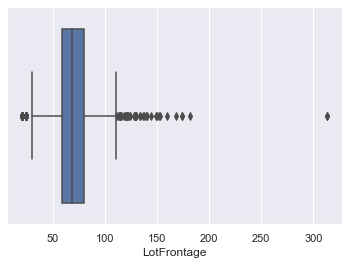

In [20]:
# Analysing column: LotFrontage (Linear feet of street connected to property)
# This column has ~17% missing values, and since box plot shows presence of outliers.
# Imputing the column missing values with median values and not doing the outlier treatment since it's highly skewed
print(missing_values_table_columnwise(saleprice_df)[1:2])
sns.boxplot(saleprice_df['LotFrontage'])
saleprice_df['LotFrontage'].fillna(saleprice_df['LotFrontage'].median(),inplace=True)

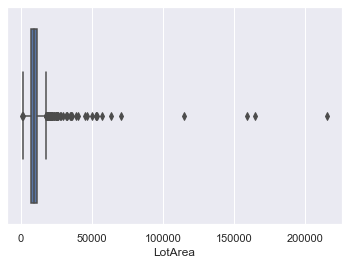

In [21]:
# Analysing column: LotArea (Lot size in square feet)
# This column doesn't have any missing values, but since box plot shows presence of outliers.
saleprice_df['LotArea'].isna().sum()
sns.boxplot(saleprice_df['LotArea'])

In [22]:
# Create a new dataframe which contains categorical variables.
print("shape of original df:", saleprice_df.shape)
saleprice_cat_df = saleprice_df.select_dtypes(exclude=np.number)
print("shape of categorical df:", saleprice_cat_df.shape)
saleprice_cat_df.head()

shape of original df: (1460, 73)
shape of categorical df: (1460, 38)


MSZoning LotShape LandContour Utilities LotConfig LandSlope Neighborhood  \
0       RL      Reg         Lvl    AllPub    Inside       Gtl      CollgCr   
1       RL      Reg         Lvl    AllPub       FR2       Gtl      Veenker   
2       RL      IR1         Lvl    AllPub    Inside       Gtl      CollgCr   
3       RL      IR1         Lvl    AllPub    Corner       Gtl      Crawfor   
4       RL      IR1         Lvl    AllPub       FR2       Gtl      NoRidge   

  Condition1 Condition2 BldgType  ... KitchenQual Functional FireplaceQu  \
0       Norm       Norm     1Fam  ...          Gd        Typ         NaN   
1      Feedr       Norm     1Fam  ...          TA        Typ          TA   
2       Norm       Norm     1Fam  ...          Gd        Typ          TA   
3       Norm       Norm     1Fam  ...          Gd        Typ          Gd   
4       Norm       Norm     1Fam  ...          Gd        Typ          TA   

  GarageType GarageFinish GarageQual GarageCond PavedDrive SaleType  \
0     Attchd          RFn         TA         TA          Y       WD   
1     Attchd          RFn         TA         TA          Y       WD   
2     Attchd          RFn         TA         TA          Y       WD   
3     Detchd          Unf         TA         TA          Y       WD   
4     Attchd          RFn         TA         TA          Y       WD   

  SaleCondition  
0        Normal  
1        Normal  
2        Normal  
3       Abnorml  
4        Normal  

[5 rows x 38 columns]

In [23]:
# Create a new dataframe which contains numeric variables.
print("shape of original df:", saleprice_df.shape)
saleprice_quant_df = saleprice_df.select_dtypes(include=np.number)
print("shape of quantitative df:", saleprice_cat_df.shape)
saleprice_quant_df.head()

shape of original df: (1460, 73)
shape of quantitative df: (1460, 38)


MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  \
0          60         65.0     8450            7            5       2003   
1          20         80.0     9600            6            8       1976   
2          60         68.0    11250            7            5       2001   
3          70         60.0     9550            7            5       1915   
4          60         84.0    14260            8            5       2000   

   YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2  ...  GarageCars  \
0          2003       196.0         706           0  ...           2   
1          1976         0.0         978           0  ...           2   
2          2002       162.0         486           0  ...           2   
3          1970         0.0         216           0  ...           3   
4          2000       350.0         655           0  ...           3   

   GarageArea  WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  \
0         548           0           61              0          0            0   
1         460         298            0              0          0            0   
2         608           0           42              0          0            0   
3         642           0           35            272          0            0   
4         836         192           84              0          0            0   

   MoSold  YrSold  SalePrice  
0       2    2008     208500  
1       5    2007     181500  
2       9    2008     223500  
3       2    2006     140000  
4      12    2008     250000  

[5 rows x 35 columns]

In [24]:
#Checking how many unique values are there in each of the categorical column
value_counts = []
for col in saleprice_cat_df:
    value_counts.append(len(saleprice_cat_df[col].value_counts()))
data_val = {'categorical col': saleprice_cat_df.columns, 'value counts': value_counts}
pd.DataFrame(data_val)

categorical col  value counts
0         MSZoning             5
1         LotShape             4
2      LandContour             4
3        Utilities             2
4        LotConfig             5
5        LandSlope             3
6     Neighborhood            25
7       Condition1             9
8       Condition2             8
9         BldgType             5
10      HouseStyle             8
11       RoofStyle             6
12        RoofMatl             8
13     Exterior1st            15
14     Exterior2nd            16
15      MasVnrType             4
16       ExterQual             4
17       ExterCond             5
18      Foundation             6
19        BsmtQual             4
20        BsmtCond             4
21    BsmtExposure             4
22    BsmtFinType1             6
23    BsmtFinType2             6
24         Heating             6
25       HeatingQC             5
26      CentralAir             2
27      Electrical             5
28     KitchenQual             4
29      Functional             7
30     FireplaceQu             5
31      GarageType             6
32    GarageFinish             3
33      GarageQual             5
34      GarageCond             5
35      PavedDrive             3
36        SaleType             9
37   SaleCondition             6

#### Analyse Variables

In [25]:
saleprice_cat_df.columns

Index(['MSZoning', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
       'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional',
       'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
       'PavedDrive', 'SaleType', 'SaleCondition'],
      dtype='object')

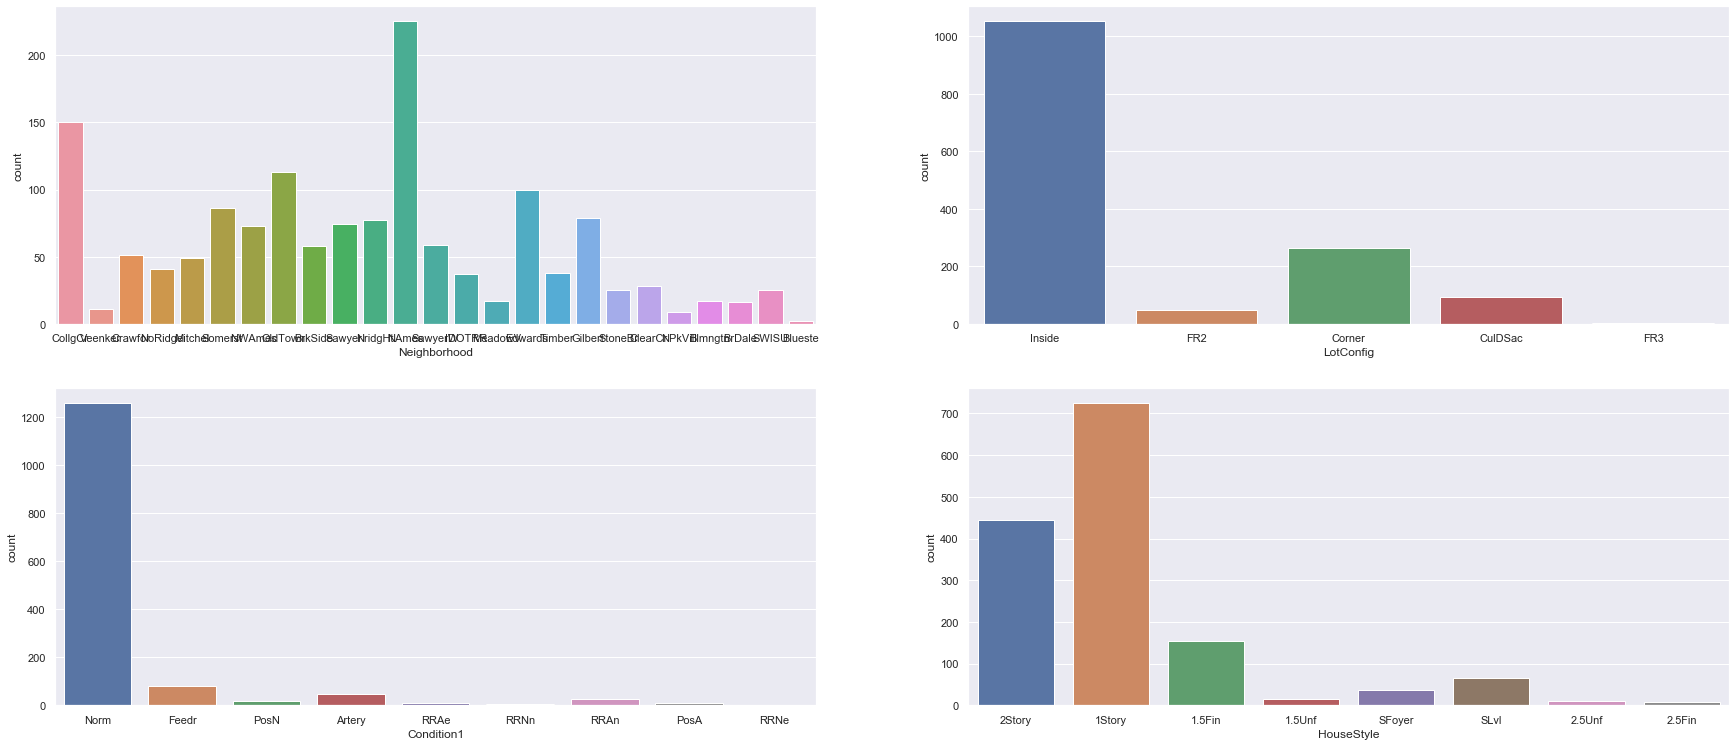

Neighborhood
NAmes      225
CollgCr    150
OldTown    113
Edwards    100
Somerst     86
Gilbert     79
NridgHt     77
Sawyer      74
NWAmes      73
SawyerW     59
BrkSide     58
Crawfor     51
Mitchel     49
NoRidge     41
Timber      38
IDOTRR      37
ClearCr     28
StoneBr     25
SWISU       25
MeadowV     17
Blmngtn     17
BrDale      16
Veenker     11
NPkVill      9
Blueste      2
Name: Neighborhood, dtype: int64
LotConfig
Inside     1052
Corner      263
CulDSac      94
FR2          47
FR3           4
Name: LotConfig, dtype: int64
Condition1
Norm      1260
Feedr       81
Artery      48
RRAn        26
PosN        19
RRAe        11
PosA         8
RRNn         5
RRNe         2
Name: Condition1, dtype: int64
HouseStyle
1Story    726
2Story    445
1.5Fin    154
SLvl       65
SFoyer     37
1.5Unf     14
2.5Unf     11
2.5Fin      8
Name: HouseStyle, dtype: int64


In [26]:
# Analysing categorical
# Neighborhood: Physical locations within Ames city limits
# LotConfig: Lot configuration
# Condition1: Proximity to various conditions
# HouseStyle: Style of dwelling
# OverallQual: Rates the overall material and finish of the house
# OverallCond: Rates the overall condition of the house
# Visualise, check value counts and then identify some category levels having less data point, we combine in a label
# Next we visualise the data again to observe the change and
categorical_columns = ['Neighborhood','LotConfig','Condition1','HouseStyle']
make_plot(categorical_columns)

for col in categorical_columns:
    print(col)
    print(saleprice_cat_df[col].value_counts())

saleprice_df['Neighborhood'].replace(to_replace=['NPkVill','Veenker','Blueste'], value='Other',inplace=True)
saleprice_df['LotConfig'].replace(to_replace=['FR2','FR3'],value="FR2+3",inplace=True)
saleprice_df['Condition1'].replace(to_replace=['PosA''RRNn','RRNe'], value = 'Other',inplace=True)
saleprice_df['HouseStyle'].replace(to_replace=['1.5Unf','2.5Unf','2.5Fin'],value='Unf',inplace=True)

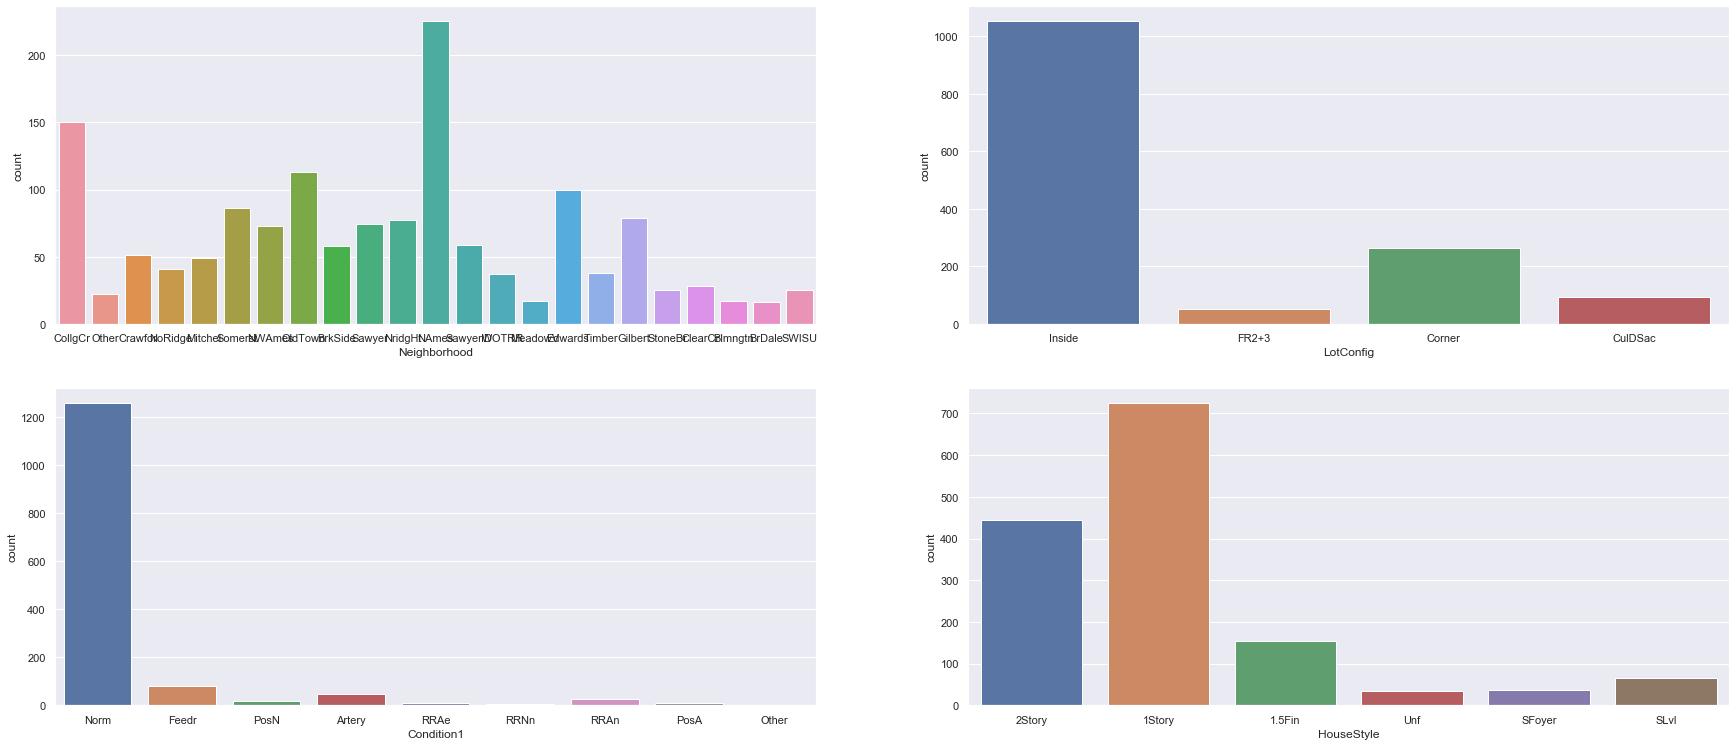

In [27]:
# Visualise the categorical columns as a box plot
make_plot(categorical_columns, 'box')

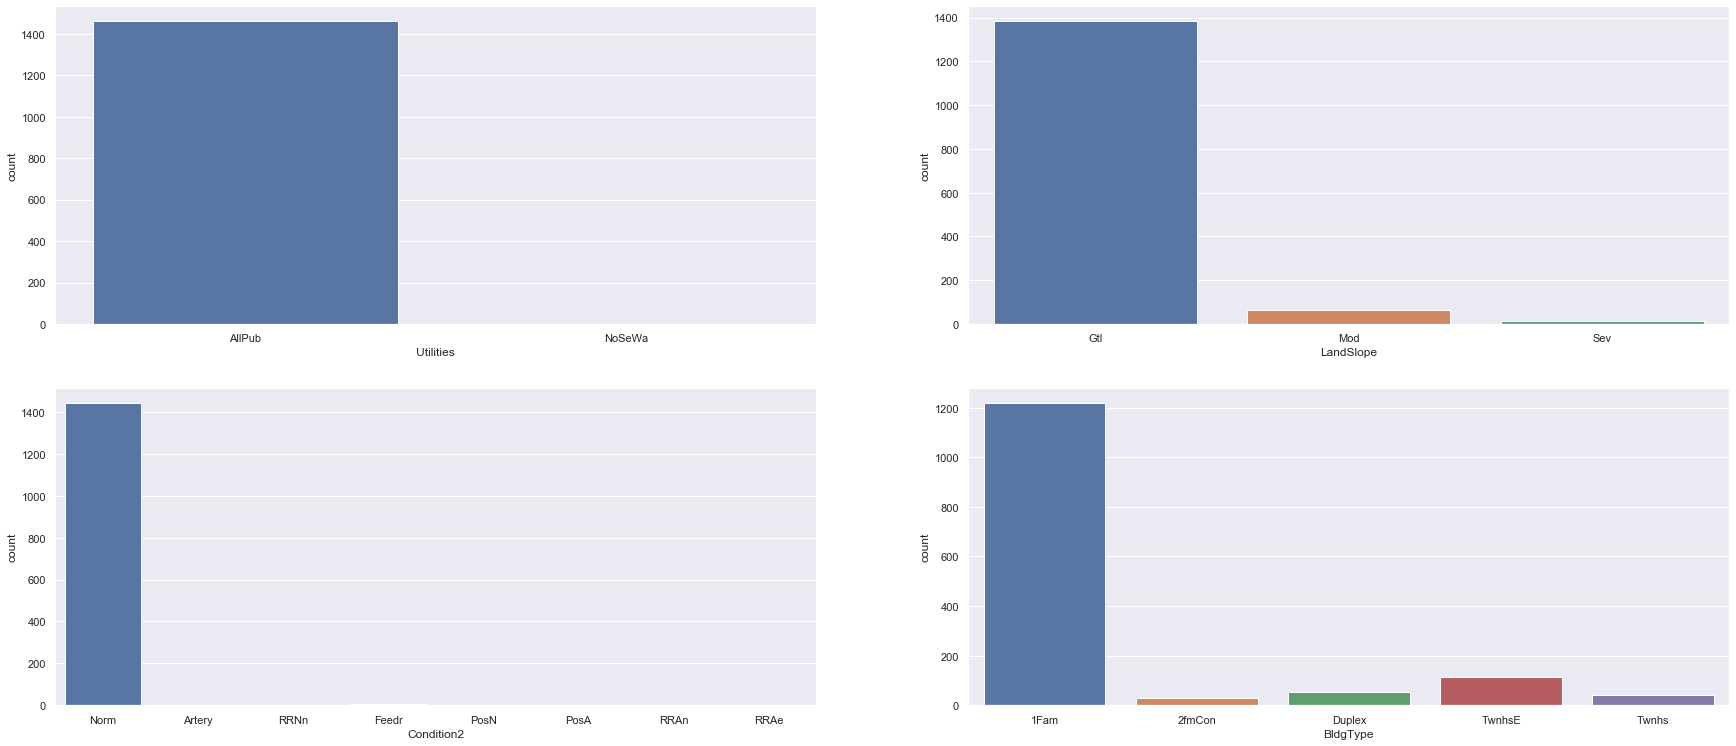

In [28]:
# Analysing categorical
# Neighborhood: Physical locations within Ames city limits
# LotConfig: Lot configuration
# Condition1: Proximity to various conditions
# HouseStyle: Style of dwelling
# Most of the visualisation of these variables show that categories are skewed and won't help in prediction
# Some categories are showing redundant information. Dropping such categories
categorical_columns = ['Utilities','LandSlope','Condition2', 'BldgType']
make_plot(categorical_columns)
saleprice_df.drop(categorical_columns,1,inplace=True)

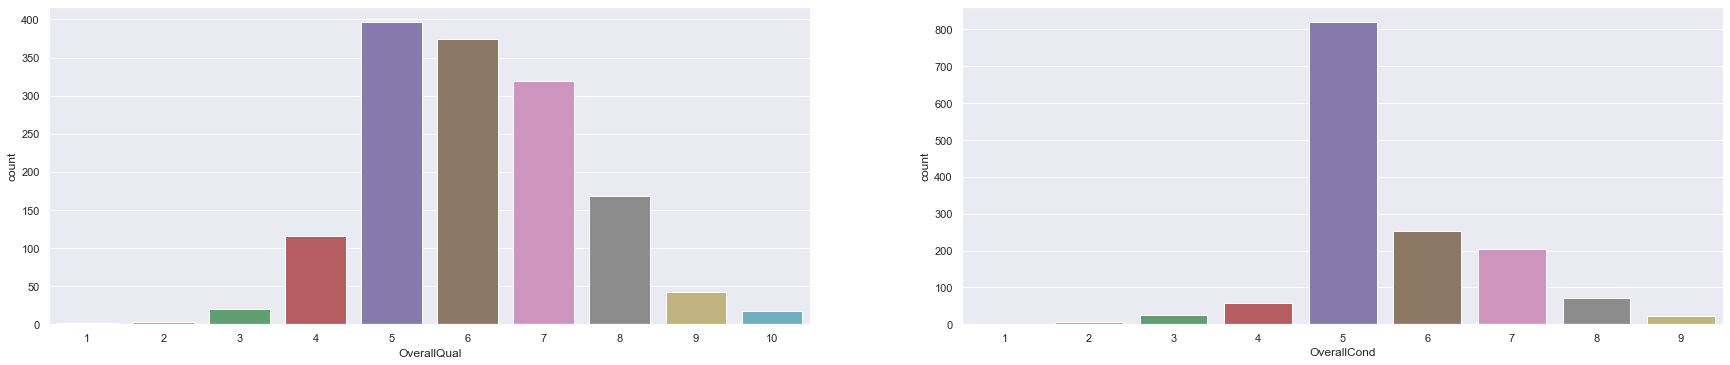

In [29]:
# Analysing numeric columns to view the distribution
# OverallCond: Rates the overall condition of the house
# OverallQual: Rates the overall material and finish of the house
to_analyse_cols = ['OverallQual', 'OverallCond']
make_plot(to_analyse_cols)

In [30]:
# Deriving columns from timeline information
# YrSold: Year Sold (YYYY)
# YearRemodAdd: Remodel date (same as construction date if no remodeling or additions)
# YearBuilt: Original construction date
# MoSold: Month Sold (MM)
# YrSold: Year Sold (YYYY)
# Finally we can drop redundant columns after fetching the derived one.
saleprice_df['House_age'] = pd.datetime.now().year - saleprice_df['YearBuilt']
saleprice_df['Remodel_age'] = pd.datetime.now().year - saleprice_df['YearRemodAdd']
# saleprice_df['House_age'] = saleprice_df['YrSold']-saleprice_df['YearBuilt']
# saleprice_df['Remodel_age'] = saleprice_df['YrSold']-saleprice_df['YearRemodAdd']
print(saleprice_df[['YearBuilt','YrSold','House_age','YearRemodAdd','Remodel_age']].head())
saleprice_df.drop(['YearBuilt','YearRemodAdd', 'MoSold', 'YrSold'],1,inplace=True)

   YearBuilt  YrSold  House_age  YearRemodAdd  Remodel_age
0       2003    2008         17          2003           17
1       1976    2007         44          1976           44
2       2001    2008         19          2002           18
3       1915    2006        105          1970           50
4       2000    2008         20          2000           20


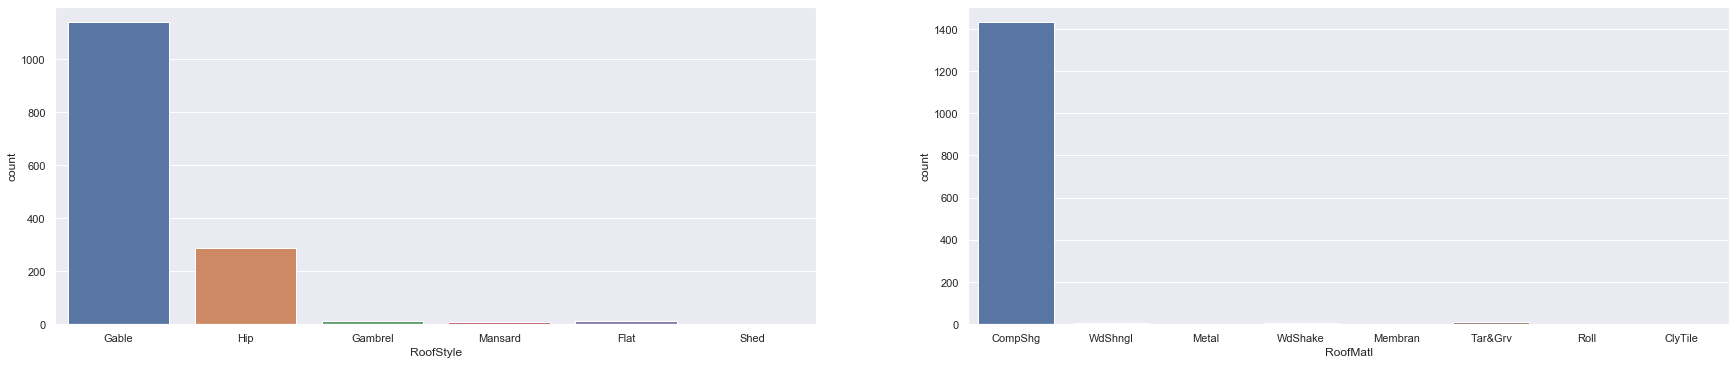

In [31]:
# Analysing categorical
# RoofStyle: Type of roof
# RoofMatl: Roof material
# Most of the visualisation of these variables show that categories are skewed and won't help in prediction
# Some categories are showing redundant information. Dropping such categories
categorical_columns = ['RoofStyle','RoofMatl']
make_plot(categorical_columns)
saleprice_df['RoofStyle'].replace(to_replace=['Mansard','Shed'],value='Other',inplace=True)
saleprice_df.drop(categorical_columns,1,inplace=True)

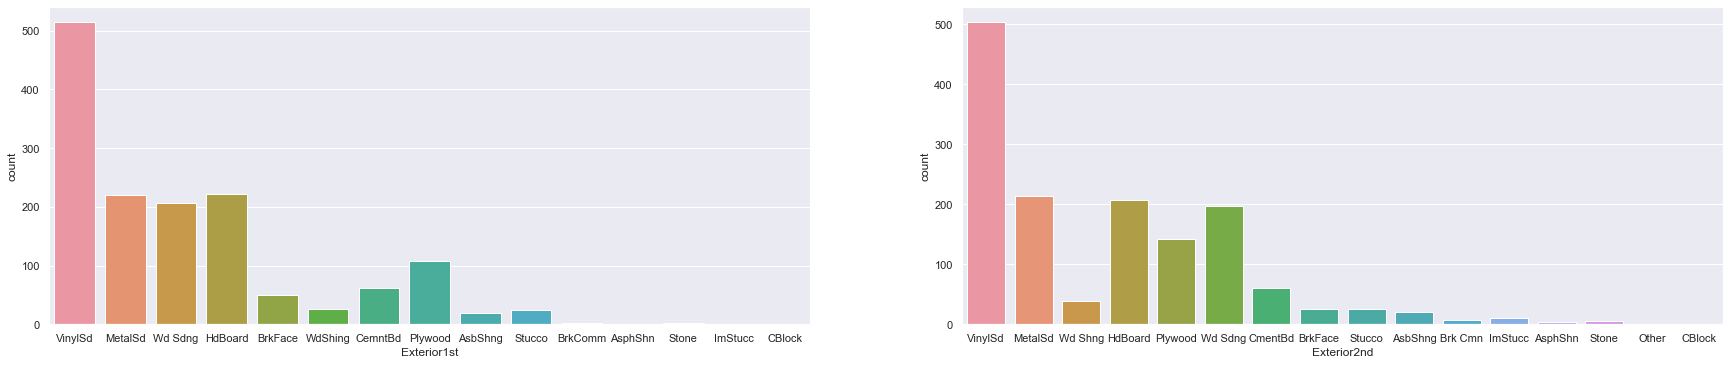

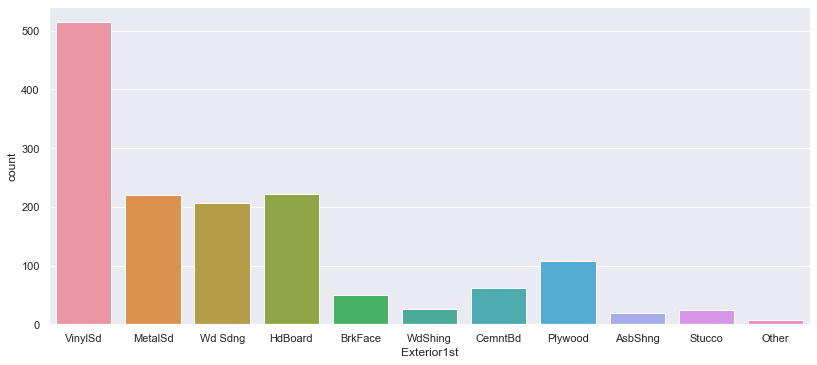

In [32]:
# Analysing categorical
# Exterior1st: Exterior covering on house
# Exterior2nd: Exterior covering on house (if more than one material)
# Visualise, check value counts and then identify Exterior1st and Exterior2nd are showing similar trends.
# Thus dropping Exterior2nd. Next we visualise the data again to observe the change
categorical_columns = ['Exterior1st','Exterior2nd']
make_plot(categorical_columns)
saleprice_df['Exterior1st'].replace(to_replace=['BrkComm','AsphShn','Stone','ImStucc','CBlock'],value='Other',inplace=True)
saleprice_df.drop(categorical_columns[-1],1,inplace=True)
make_plot(categorical_columns[:1], 'box')

None       0.595041
BrkFace    0.306474
Stone      0.088154
BrkCmn     0.010331
Name: MasVnrType, dtype: float64


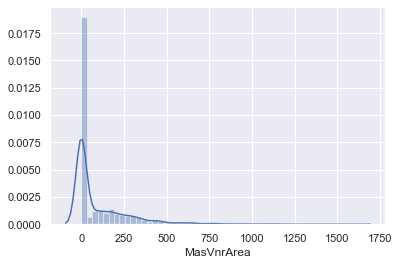

In [33]:
# Analysing categorical
# MasVnrType: Masonry veneer type
# Visualise, check value counts and then identify very few NaNs, so drop such rows.
print(saleprice_df['MasVnrType'].value_counts(True))
saleprice_df = saleprice_df[~pd.isnull(saleprice_df['MasVnrType'])]
sns.distplot(saleprice_df['MasVnrArea'])

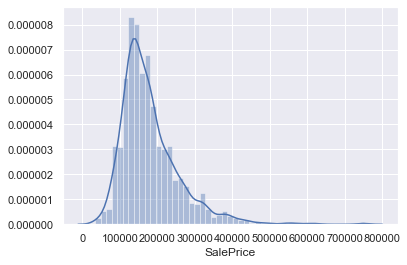

In [34]:
# Analysing target variable; SalePrice
# We observe right skewed data for SalePrice
# replace the SalePrice with log values to normalise
sns.distplot(saleprice_df['SalePrice'])
saleprice_df['SalePrice'] = np.log(saleprice_df['SalePrice'])

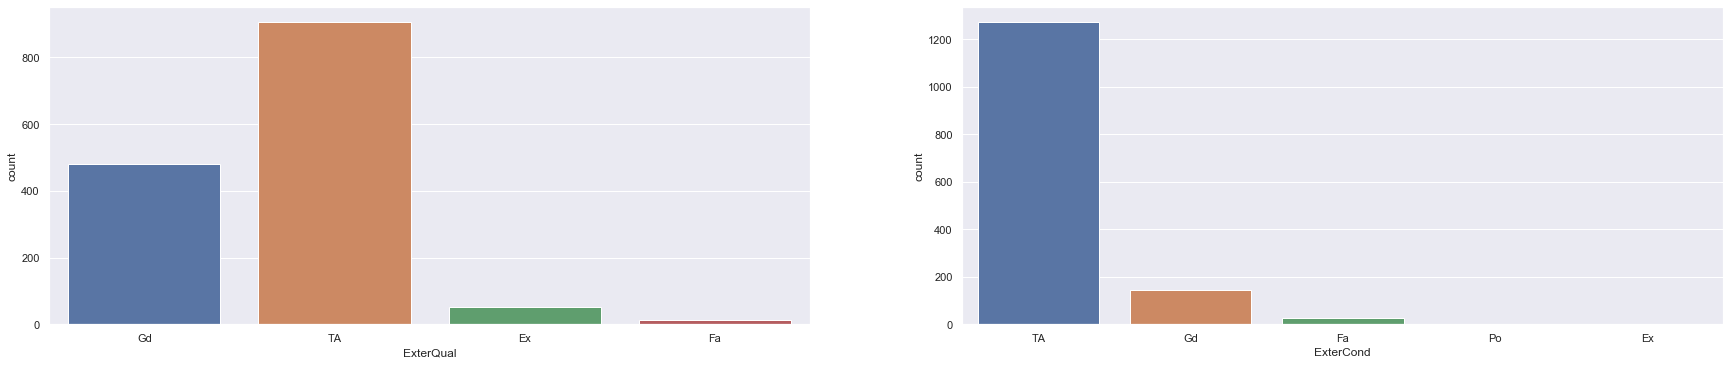

ExterQual  ExterCond  SalePrice
ExterQual    1.00000    0.01091    0.67703
ExterCond    0.01091    1.00000    0.05046
SalePrice    0.67703    0.05046    1.00000

In [35]:
# Analysing categorical
# ExterQual: Evaluates the quality of the material on the exterior 
# ExterCond: Evaluates the present condition of the material on the exterior
# Visualise, check value counts and then identify convert into numerical and analyse the correlation with target var
categorical_columns = ['ExterQual','ExterCond']
make_plot(categorical_columns)
saleprice_df['ExterQual']=saleprice_df['ExterQual'].map({'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1})
saleprice_df['ExterCond']=saleprice_df['ExterCond'].map({'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1})
saleprice_df[['ExterQual','ExterCond','SalePrice']].corr()

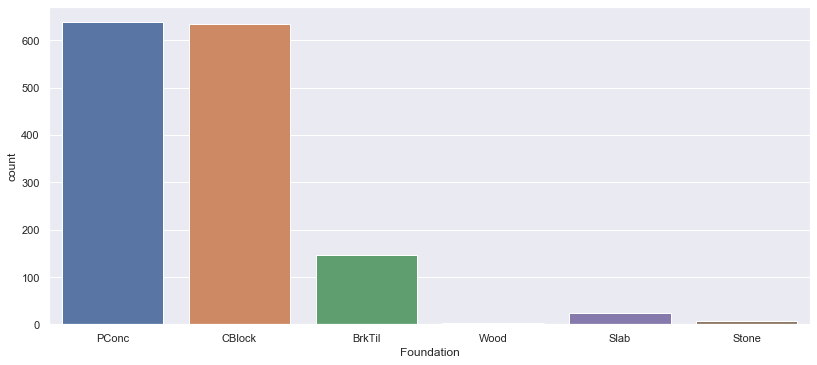

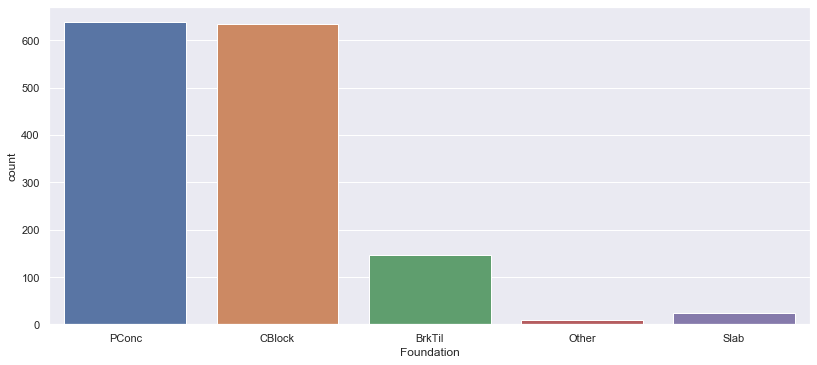

In [36]:
# Analysing categorical
# Foundation: Type of foundation
# Visualise, check value counts and then identify Exterior1st and Exterior2nd are showing similar trends.
# Thus dropping Exterior2nd. Next we visualise the data again to observe the change
make_plot(['Foundation'])
saleprice_df['Foundation'].replace(to_replace=['Stone','Wood'], value='Other',inplace=True)
make_plot(['Foundation'], 'box')

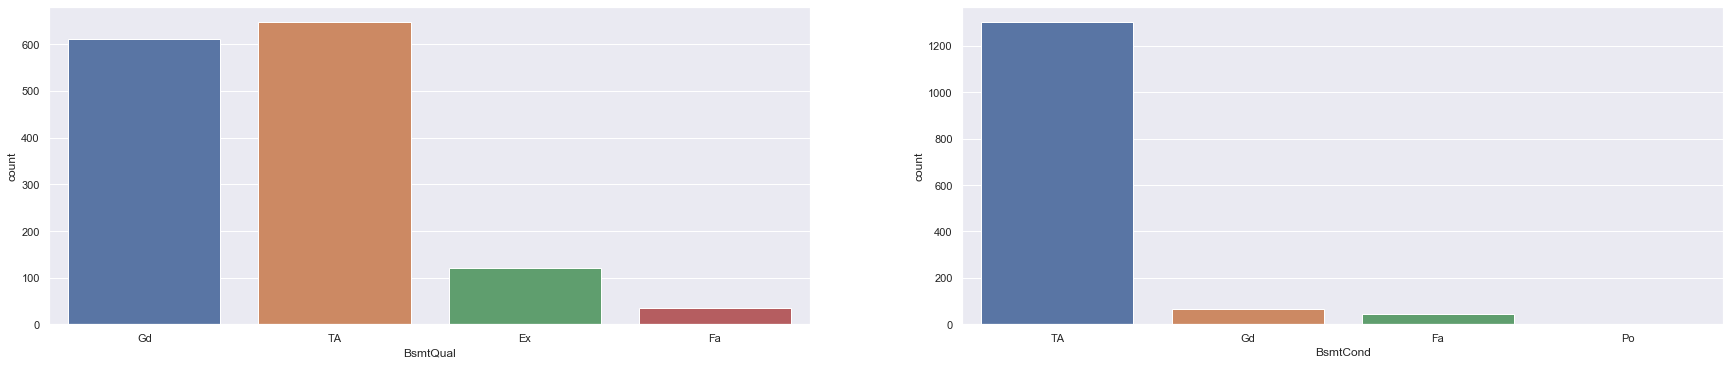

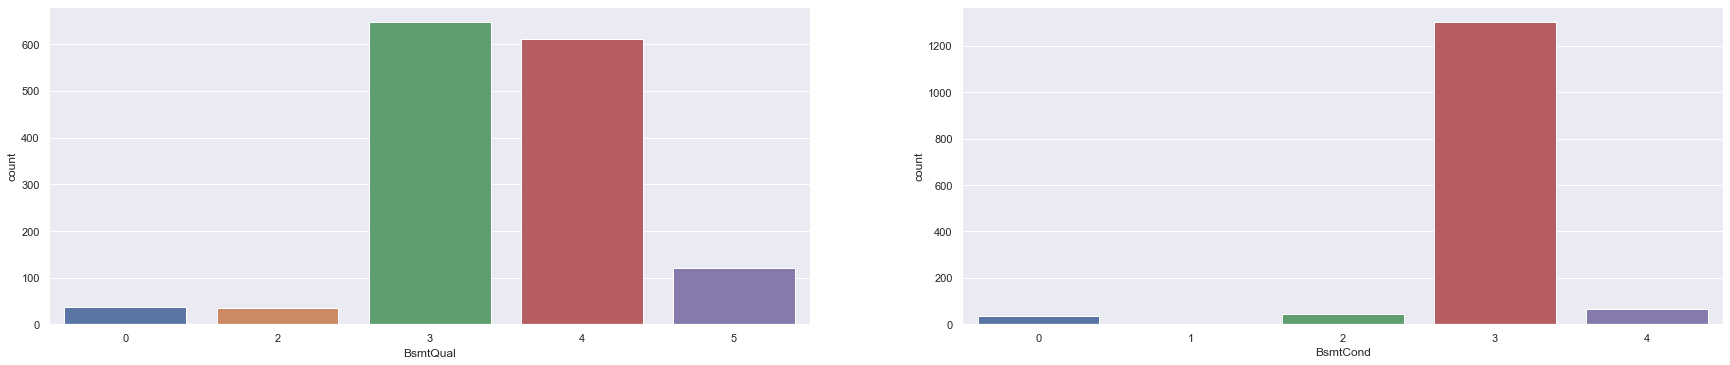

           BsmtQual  BsmtCond  SalePrice
BsmtQual   1.000000  0.633179   0.614680
BsmtCond   0.633179  1.000000   0.272023
SalePrice  0.614680  0.272023   1.000000


In [37]:
# Analysing categorical
# BsmtQual: Evaluates the height of the basement
# BsmtCond, Evaluates the general condition of the basement
# Fill NA values and convert these into numeric columns
# Imputing Na with 'NB'(No Basement) and since both highly correlated, dropping one column BsmtCond
to_analyse_cols = ['BsmtQual', 'BsmtCond']
make_plot(to_analyse_cols)
saleprice_df['BsmtQual'].fillna('NB',inplace=True)
saleprice_df['BsmtCond'].fillna('NB',inplace=True)
saleprice_df['BsmtQual']=saleprice_df['BsmtQual'].map({'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, 'NB':0})
saleprice_df['BsmtCond']=saleprice_df['BsmtCond'].map({'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, 'NB':0})
make_plot(to_analyse_cols, 'box')
print((saleprice_df[to_analyse_cols + ['SalePrice']]).corr())
saleprice_df.drop('BsmtCond',1,inplace=True)

No    946
Av    221
Gd    133
Mn    114
Name: BsmtExposure, dtype: int64


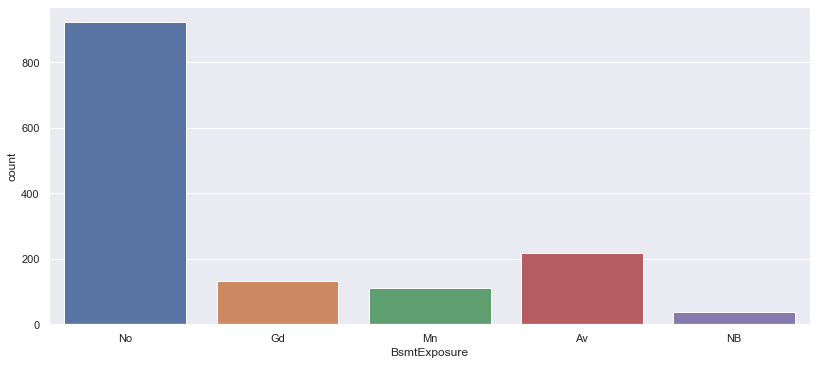

In [38]:
# Analysing categorical
# BsmtExposure: Refers to walkout or garden level walls
# If BsmtQual is equal to zero, we inferred it as NB i.e No Basement.
# We should apply same rule for 'BsmtExposure' and also remove missing values
print(saleprice_df['BsmtExposure'].value_counts())
for idx, value in enumerate(saleprice_df.BsmtQual):
    if value is 0:
        saleprice_df.BsmtExposure[idx]= 'NB'
saleprice_df = saleprice_df[~pd.isnull(saleprice_df['BsmtExposure'])]
make_plot(['BsmtExposure'])

Unf    427
GLQ    413
ALQ    220
BLQ    148
Rec    132
LwQ     74
Name: BsmtFinType1, dtype: int64


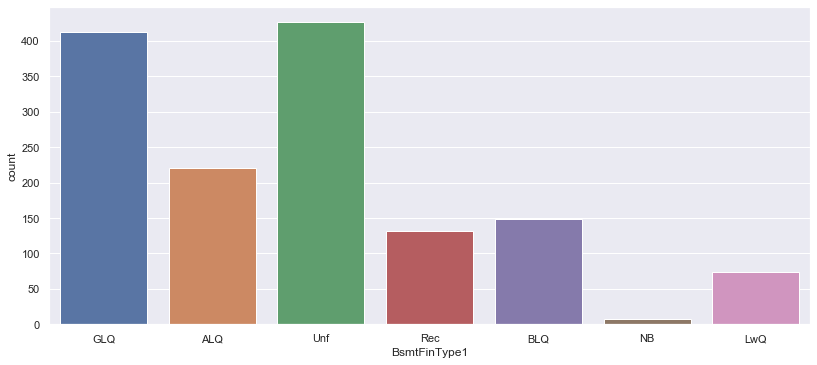

In [39]:
# Analysing categorical
# BsmtFinType1: Rating of basement finished area
# Convert into numeric mapping and fill missing values with NB
print(saleprice_df['BsmtFinType1'].value_counts())
saleprice_df.BsmtFinType1.fillna('NB', inplace=True)
make_plot(['BsmtFinType1'])
saleprice_df['BsmtFinType1']=saleprice_df['BsmtFinType1'].map({'GLQ':5, 'ALQ':4, 'BLQ':3 , 'Rec':2,
                                                               'LwQ':1, 'Unf':0, 'NB': -1})

             TotalBsmtSF  BsmtUnfSF  SalePrice
TotalBsmtSF     1.000000   0.381397   0.598578
BsmtUnfSF       0.381397   1.000000   0.196752
SalePrice       0.598578   0.196752   1.000000


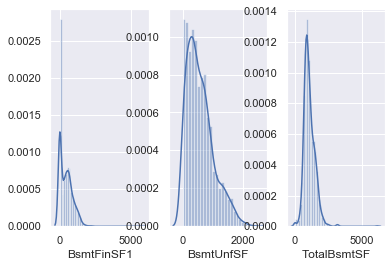

In [40]:
# Analysing categorical
# BsmtFinSF1: Type 1 finished square feet
# BsmtUnfSF: Unfinished square feet of basement area
# TotalBsmtSF: Total square feet of basement area
# Seems to be BsmtFinSF1 + BsmtFinSF2 + BsmtUnfSF = TotalBsmtSF,
# check the correlation with target variable "SalePrice" & observe TotalBsmtSF is highly correalted with Saleprice.
# Thus if we keep all the four columns, it creates redundancy in the dataset, so let's drop redundant columns
plt.subplot(1,3,1)
sns.distplot(saleprice_df.BsmtFinSF1)
plt.subplot(1,3,2)
sns.distplot(saleprice_df.BsmtUnfSF)
plt.subplot(1,3,3)
sns.distplot(saleprice_df.TotalBsmtSF)
print(saleprice_df[['TotalBsmtSF','BsmtUnfSF','SalePrice']].corr())
saleprice_df.drop(['BsmtFinType2','BsmtFinSF2','BsmtUnfSF','BsmtFinSF1'],1,inplace=True)

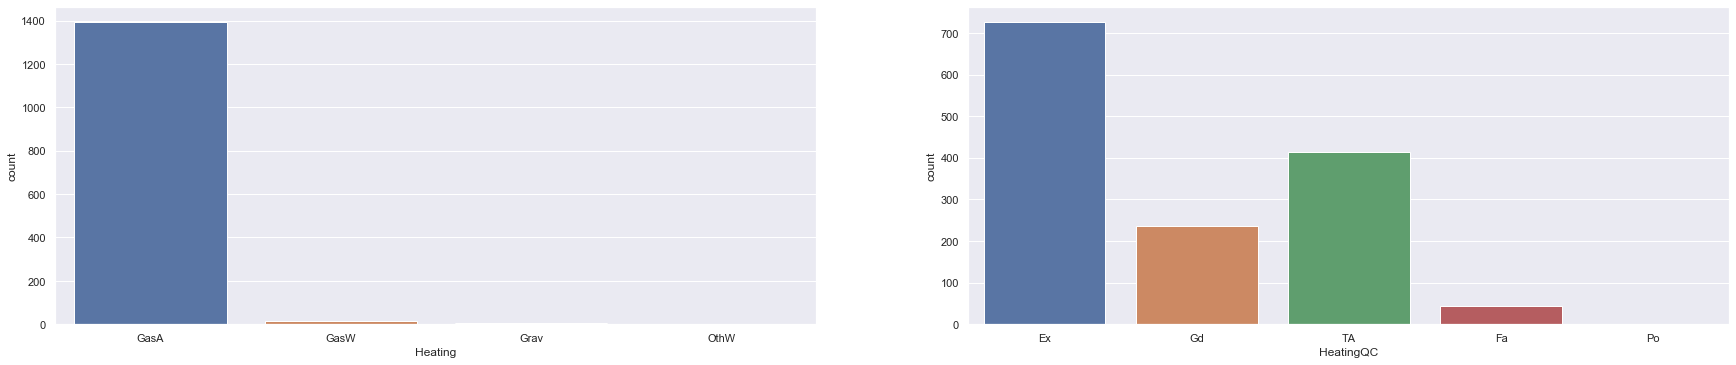

In [41]:
# Analysing categorical
# Heating: Type of heating
# HeatingQC: Heating quality and condition
# Visualise, it shows that Heating column is highly skewed, so dropping this column from the dataset
# and mapping HeatingQC to numeric column
categorical_columns = ['Heating','HeatingQC']
make_plot(categorical_columns)
saleprice_df['HeatingQC']=saleprice_df['HeatingQC'].map({'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1})
saleprice_df.drop('Heating',1,inplace=True)

Y    1339
N      82
Name: CentralAir, dtype: int64


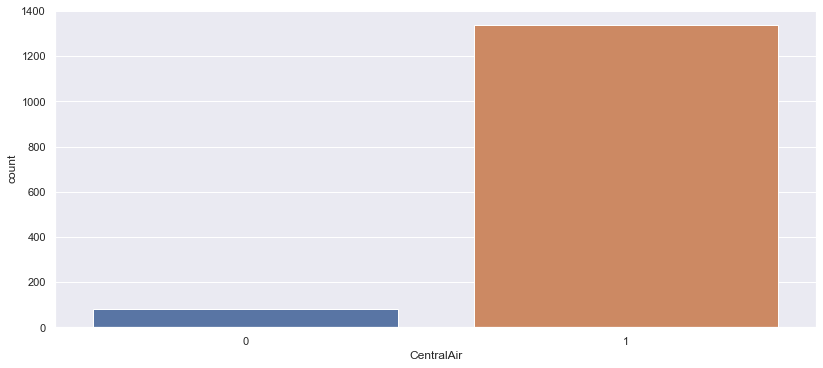

In [42]:
# Analysing categorical
# CentralAir: Central air conditioning
# Visualise the column and map to numeric values
print(saleprice_df.CentralAir.value_counts())
saleprice_df['CentralAir']=saleprice_df['CentralAir'].map({'Y':1,'N':0})
make_plot(['CentralAir'])

SBrkr    1305
FuseA      89
FuseF      22
FuseP       3
Mix         1
Name: Electrical, dtype: int64


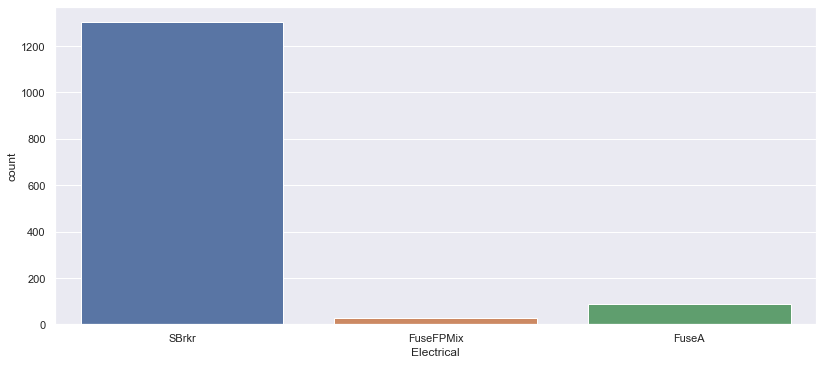

In [43]:
# Analysing categorical
# Electrical: Electrical system
# Visualise, check value_counts, replace and reduce no. of level using 'FuseFPMix' value
# Then finally remove null values and visualise the plot
print(saleprice_df['Electrical'].value_counts())
saleprice_df['Electrical'].replace(to_replace=['FuseF','FuseP','Mix'], value='FuseFPMix', inplace=True)
saleprice_df= saleprice_df[~pd.isnull(saleprice_df['Electrical'])]
make_plot(['Electrical'])

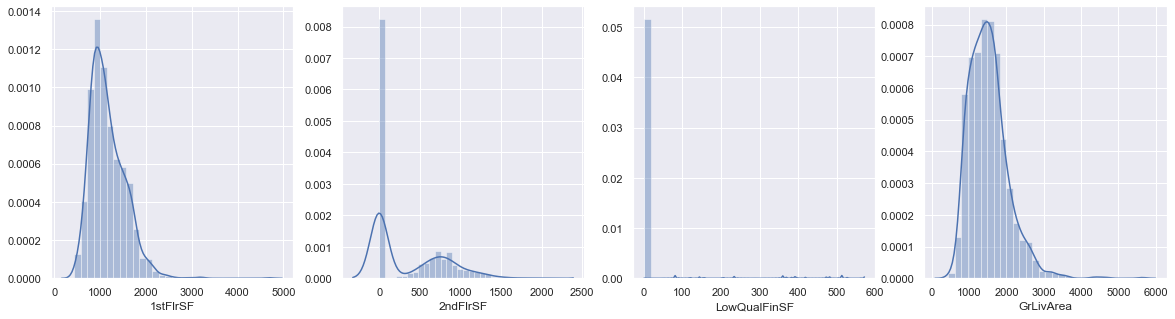

In [44]:
# Analysing categorical
# 1stFlrSF: First Floor square feet
# 2ndFlrSF: Second Floor square feet
# LowQualFinSF: Low quality finished square feet (all floors)
# GrLivArea: Above grade (ground) living area square feet
# Visualise and we find LowQualFinSF as highly skewed so let's drop this column
to_analyse_cols = ['1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea']
make_plot(df=saleprice_df[to_analyse_cols], plot='dist')
saleprice_df.drop('LowQualFinSF',1, inplace=True)

Missing values in FireplaceQu 663


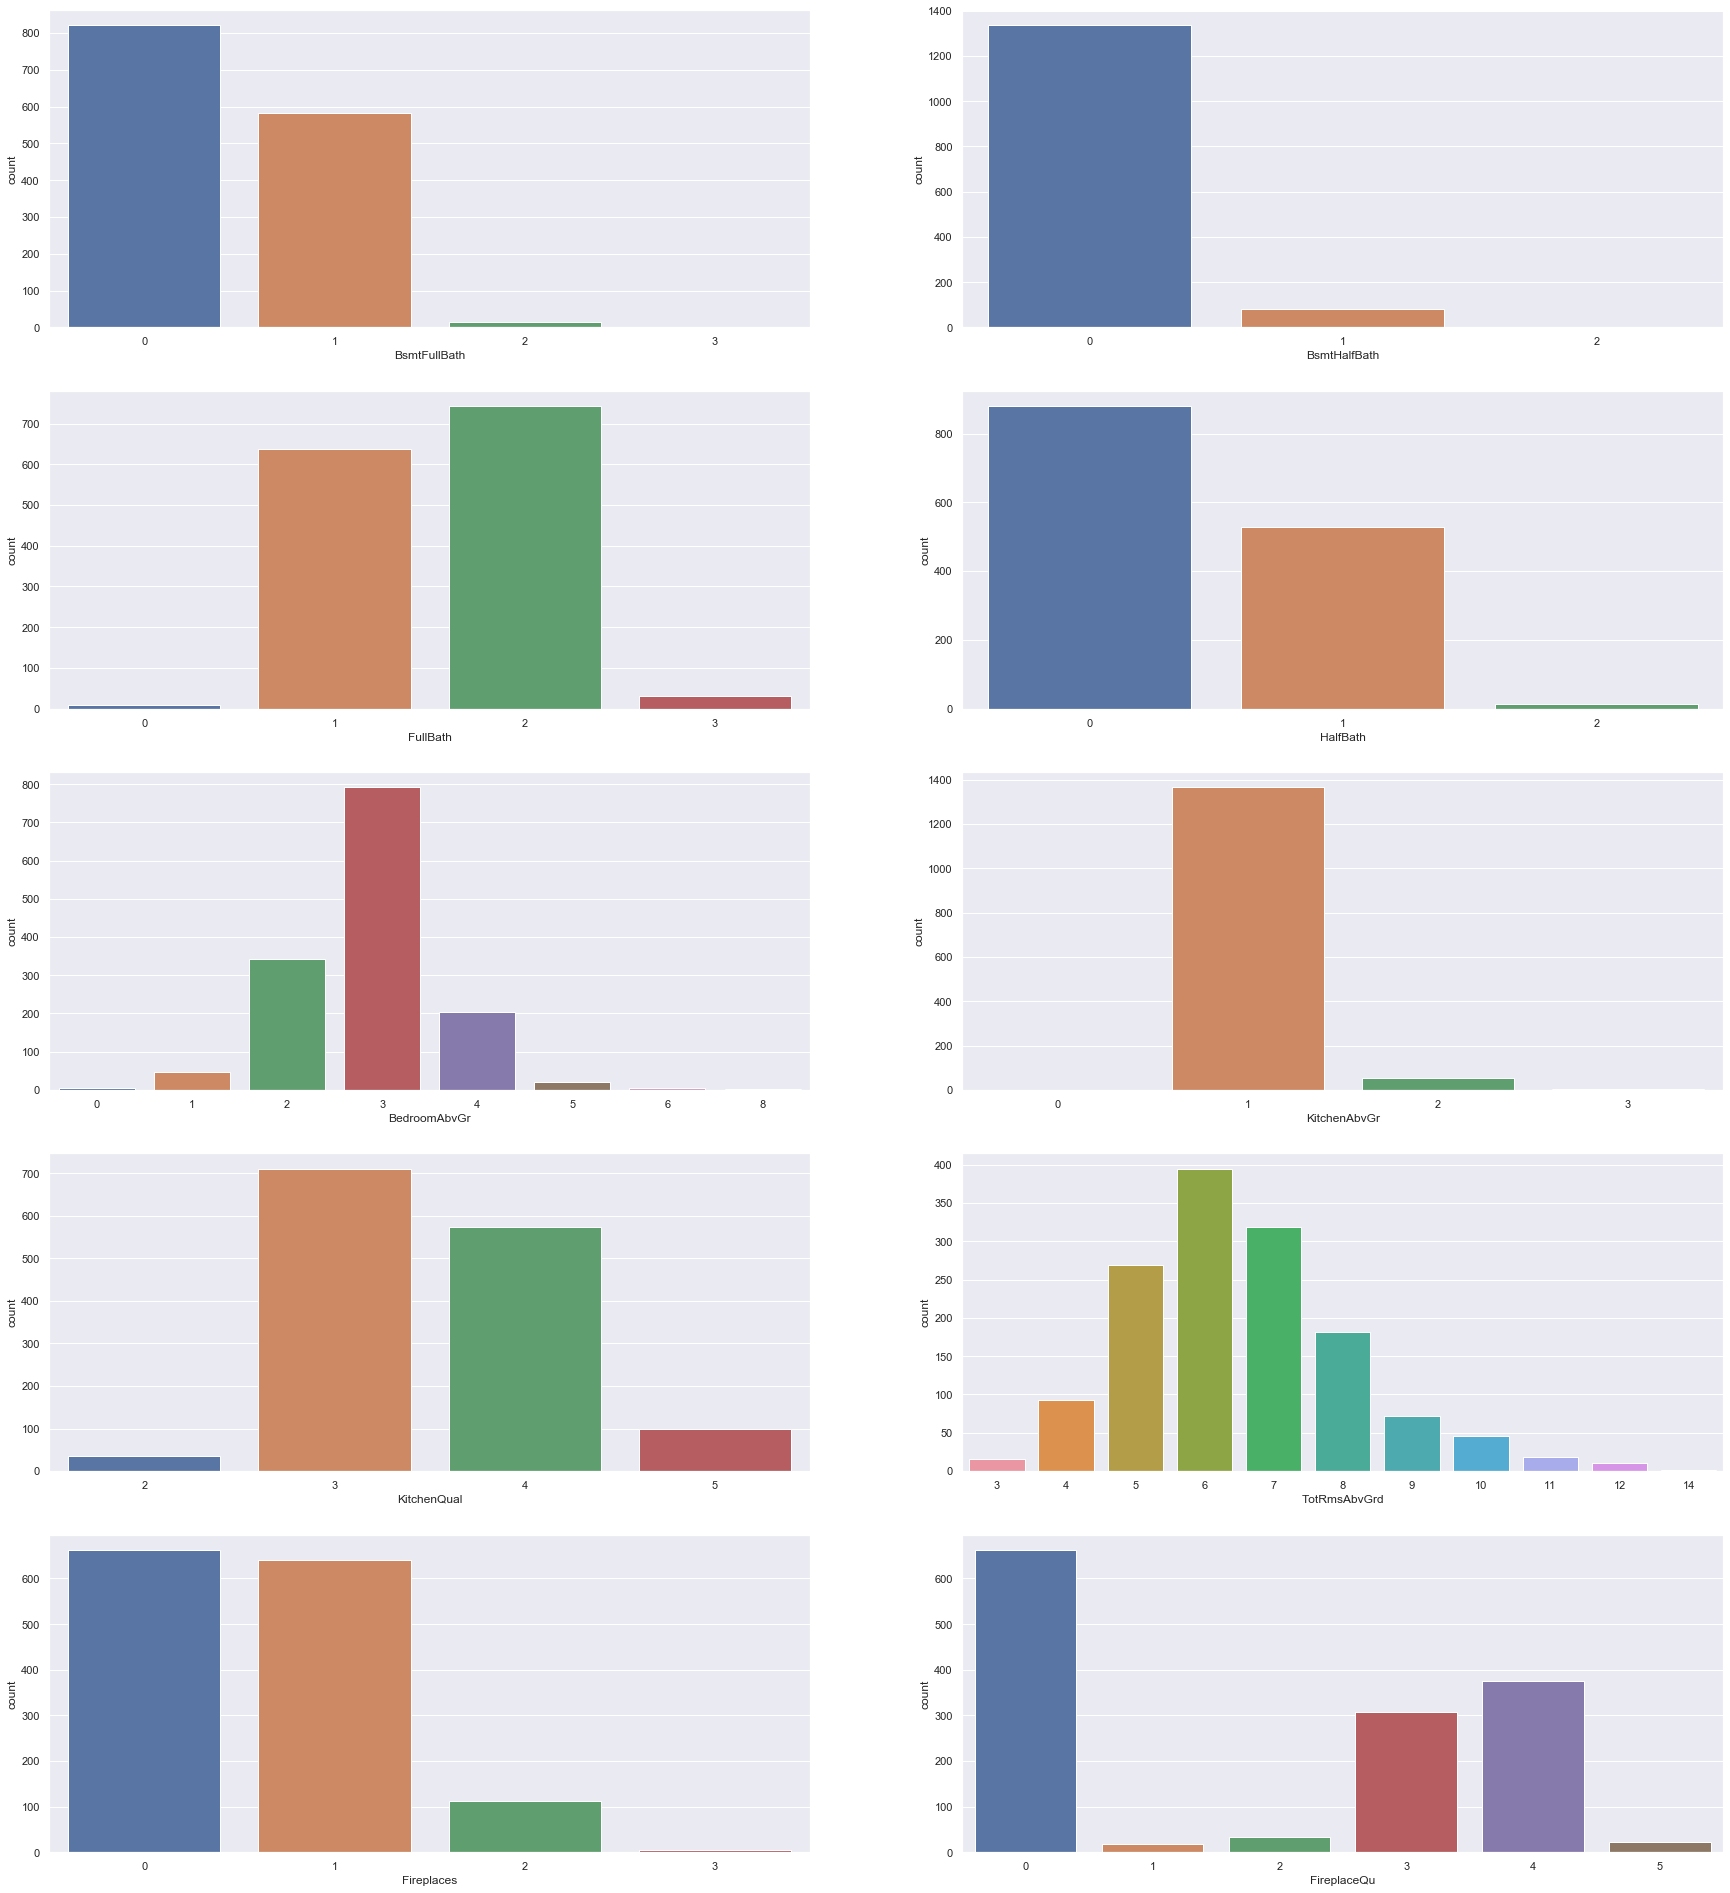

In [45]:
# Analysing categorical
# BsmtFullBath: Basement full bathrooms
# BsmtHalfBath: Basement half bathrooms
# FullBath: Full bathrooms above grade
# HalfBath: Half baths above grade
# BedroomAbvGr: Bedrooms above grade (does NOT include basement bedrooms)
# KitchenAbvGr: Kitchens above grade
# KitchenQual: Kitchen quality
# TotRmsAbvGrd: Total rooms above grade (does not include bathrooms)
# Fireplace: Number of fireplaces
# FireplaceQu: Fireplace quality
# Visualise and we convert KitchenQual and FireplaceQu into a numeric column
# Filling null values of FireplaceQu with 0 this would mean no fireplace exist
to_analyse_cols = ['BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
                   'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Fireplaces', 'FireplaceQu']
saleprice_df.KitchenQual=saleprice_df.KitchenQual.map({'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1})
print("Missing values in FireplaceQu", saleprice_df['FireplaceQu'].isna().sum())
saleprice_df['FireplaceQu'].fillna(0, inplace=True)
saleprice_df['FireplaceQu']=saleprice_df['FireplaceQu'].map({'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, 0:0})
make_plot(to_analyse_cols)

Typ     1330
Min2      31
Min1      28
Maj1      13
Mod       12
Maj2       5
Sev        1
Name: Functional, dtype: int64


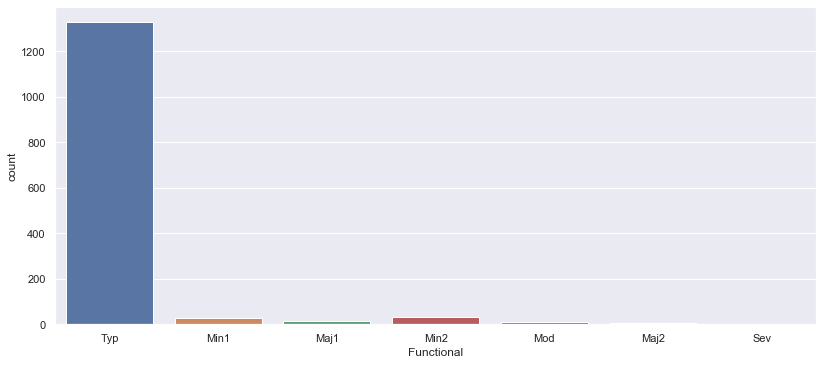

In [46]:
# Analysing categorical
# Functional: Home functionality (Assume typical unless deductions are warranted)
# Visualise and observe that this column is highly skewed, so let's drop from the dataset
print(saleprice_df['Functional'].value_counts())
make_plot(['Functional'])
saleprice_df.drop('Functional',1,inplace=True)

Your selected dataframe has 8 columns.
There are 5 columns that have missing values.
              missing_val_count  percent
GarageType                   75     5.28
GarageYrBlt                  75     5.28
GarageFinish                 75     5.28
GarageQual                   75     5.28
GarageCond                   75     5.28
            GarageCars  GarageArea  SalePrice
GarageCars    1.000000    0.880989   0.681456
GarageArea    0.880989    1.000000   0.648168
SalePrice     0.681456    0.648168   1.000000


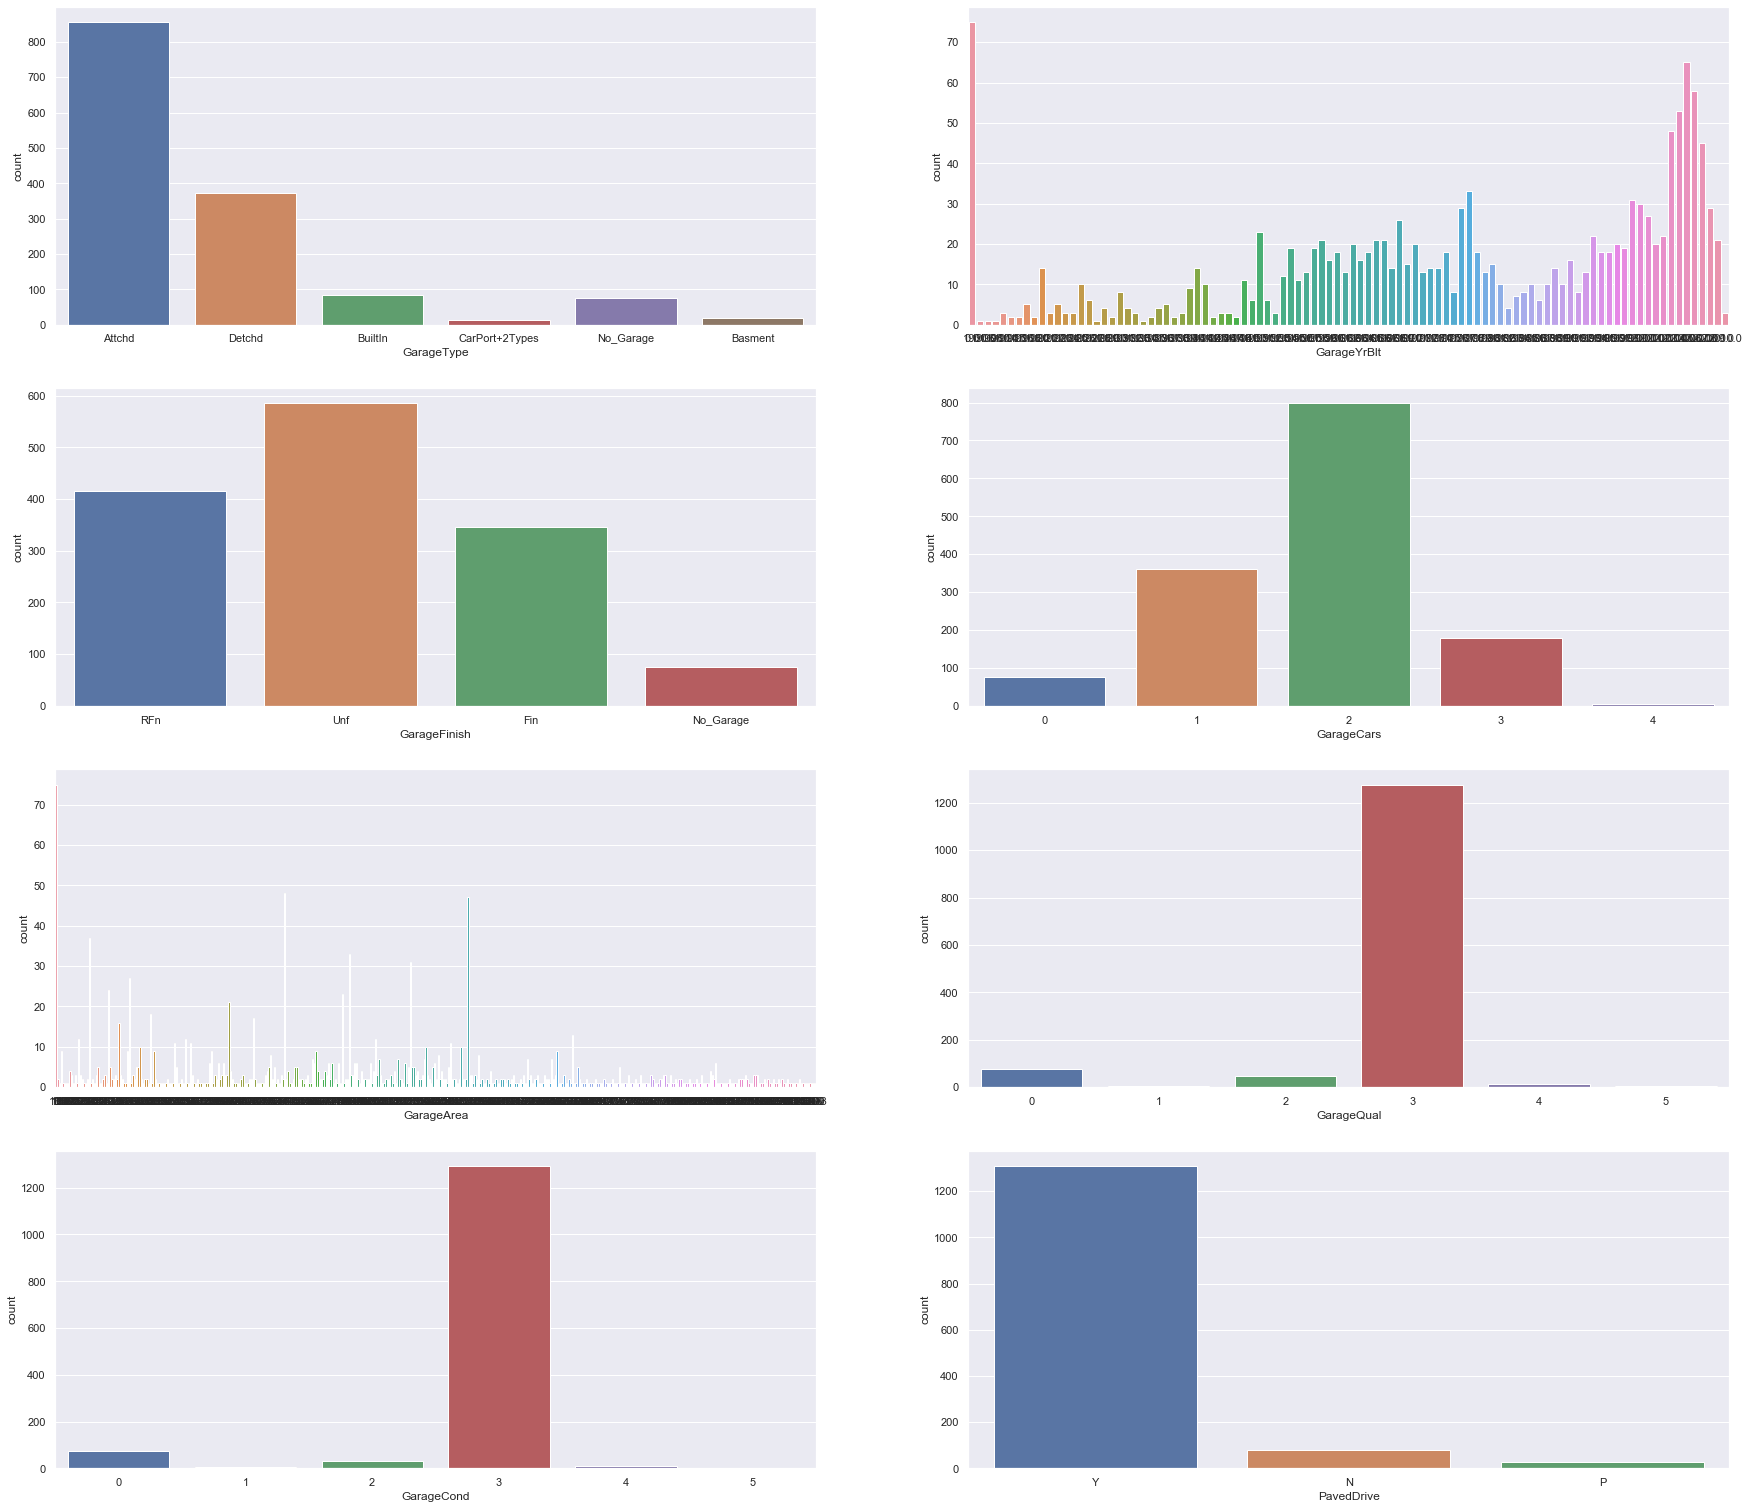

In [47]:
# Analysing categorical
# GarageType: Garage location
# GarageYrBlt: Year garage was built
# GarageFinish: Interior finish of the garage
# GarageCars: Size of garage in car capacity
# GarageArea: Size of garage in square feet
# GarageQual: Garage quality
# GarageCond: Garage condition
# PavedDrive: Paved driveway
# First find out the percentage of missing values in these columns and replace NA values, map to numeric col values
# Next find the correlation between garage columns with target variable SalePrice
# Creating a derived column of age of garage from today
# High correaltion observed between 'GarageCars','GarageArea' and 'SalePrice', dropping 'GarageCars'
# Visualise and observe that this column is highly skewed, so let's drop from the dataset
to_analyse_cols = ['GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars',
                   'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive']
missing_values_df = missing_values_table_columnwise(saleprice_df[to_analyse_cols])
print(missing_values_df.head(10))

saleprice_df['GarageType'].fillna('No_Garage', inplace=True)
saleprice_df['GarageYrBlt'].fillna(0, inplace=True)
saleprice_df['Garagebuilt_age'] = pd.datetime.now().year - saleprice_df['GarageYrBlt']
saleprice_df['GarageFinish'].fillna('No_Garage', inplace=True)
saleprice_df['GarageQual'].fillna('NG', inplace=True)
saleprice_df['GarageCond'].fillna('NG', inplace=True)
saleprice_df['GarageType'].replace(to_replace=['CarPort','2Types'], value= 'CarPort+2Types',inplace=True)
saleprice_df['GarageQual']=saleprice_df['GarageQual'].map({'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, 'NG':0})
saleprice_df['GarageCond']=saleprice_df['GarageCond'].map({'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, 'NG':0})

print(saleprice_df[['GarageCars','GarageArea','SalePrice']].corr())
make_plot(to_analyse_cols)
saleprice_df.drop('GarageCars',1,inplace=True)

WoodDeckSF  OpenPorchSF  SalePrice
WoodDeckSF     1.000000     0.051826   0.328456
OpenPorchSF    0.051826     1.000000   0.311996
SalePrice      0.328456     0.311996   1.000000

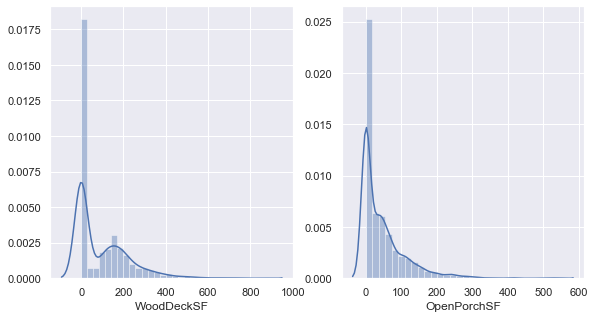

In [48]:
# Analysing numerical
# WoodDeckSF: Wood deck area in square feet
# OpenPorchSF: Open porch area in square feet
# Visualise and observe that these have not so high correlation with target variable SalePrice
to_analyse_cols = ['WoodDeckSF','OpenPorchSF']
make_plot(df=saleprice_df[to_analyse_cols], plot='dist')
saleprice_df[to_analyse_cols+['SalePrice']].corr()

               EnclosedPorch  3SsnPorch  ScreenPorch  SalePrice
EnclosedPorch       1.000000  -0.037768    -0.083952  -0.156521
3SsnPorch          -0.037768   1.000000    -0.032361   0.053730
ScreenPorch        -0.083952  -0.032361     1.000000   0.118420
SalePrice          -0.156521   0.053730     0.118420   1.000000


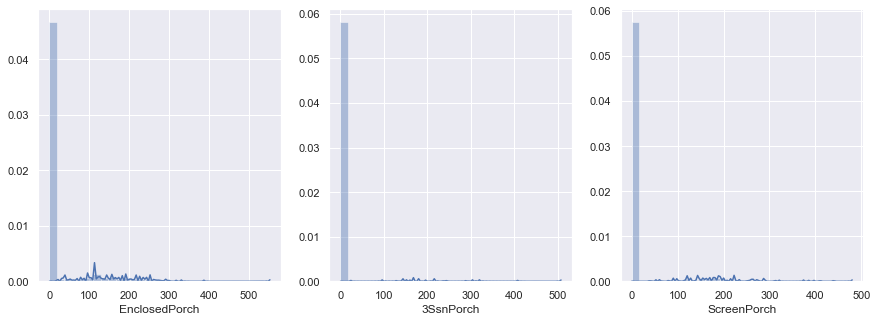

In [49]:
# Analysing numerical
# EnclosedPorch: Enclosed porch area in square feet
# 3SsnPorch: Three season porch area in square feet
# ScreenPorch: Screen porch area in square feet
# Visualise and we find columns EnclosedPorch, 3SsnPorch and ScreenPorch highly skewed
# and also have very low correlation with target variable SalePrice, so let's drop these columns
to_analyse_cols = ['EnclosedPorch','3SsnPorch','ScreenPorch']
make_plot(df=saleprice_df[to_analyse_cols], plot='dist')
print(saleprice_df[to_analyse_cols+['SalePrice']].corr())
saleprice_df.drop(['EnclosedPorch', '3SsnPorch','ScreenPorch'],1,inplace=True)

WD       1232
New       119
COD        42
ConLD       8
ConLw       5
ConLI       5
CWD         4
Oth         3
Con         2
Name: SaleType, dtype: int64 

Normal     1164
Partial     122
Abnorml     100
Family       20
Alloca       10
AdjLand       4
Name: SaleCondition, dtype: int64


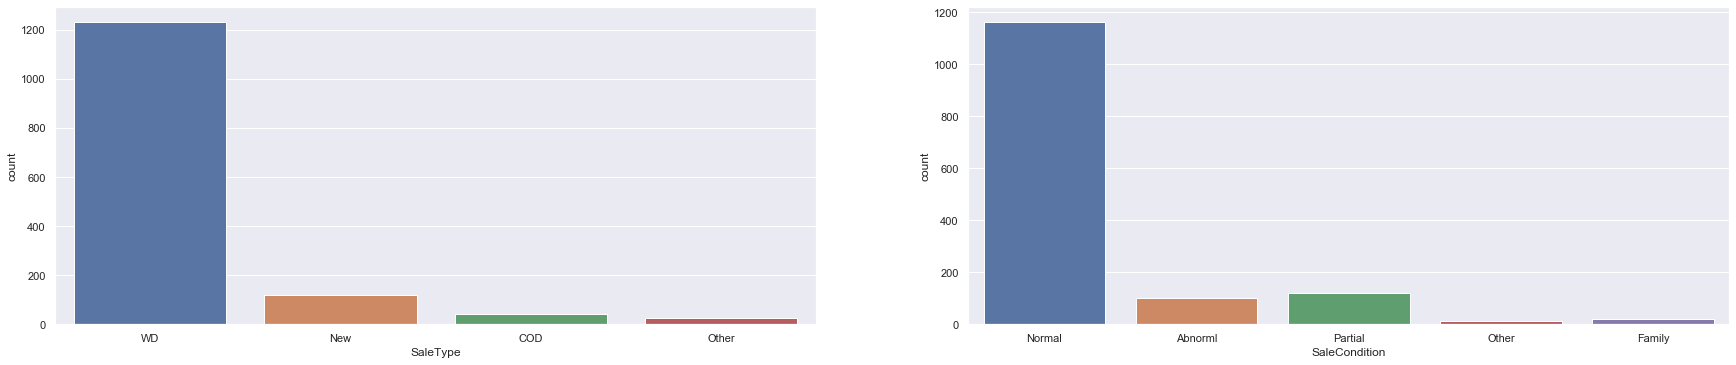

In [50]:
# Analysing categorical
# SaleType: Type of sale
# SaleCondition: Condition of sale
# First find out the percentage of missing values in these columns and replace NA values, map to numeric col values
# Next find the correlation between garage columns with target variable SalePrice
# High correaltion observed between 'GarageCars','GarageArea' and 'SalePrice', dropping 'GarageCars'
# Visualise and observe that this column is highly skewed, so let's drop from the dataset
to_analyse_cols = ['SaleType', 'SaleCondition']

print(saleprice_df['SaleType'].value_counts(), '\n')
saleprice_df['SaleType'].replace(to_replace=['ConLD','ConLI','ConLw','CWD','Oth','Con'],value='Other',inplace=True)

print(saleprice_df['SaleCondition'].value_counts())
saleprice_df['SaleCondition'].replace(to_replace=['Alloca','AdjLand'],value='Other',inplace=True)
make_plot(to_analyse_cols)

In [51]:
# Observe that we have now 1420 rows and 52 feature columns, mix of numeric and categorical columns
print('shape of saleprice_df after data cleaning:',saleprice_df.shape)
saleprice_df.info()

shape of saleprice_df after data cleaning: (1420, 53)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1420 entries, 0 to 1459
Data columns (total 53 columns):
MSSubClass         1420 non-null int64
MSZoning           1420 non-null object
LotFrontage        1420 non-null float64
LotArea            1420 non-null int64
LotShape           1420 non-null object
LandContour        1420 non-null object
LotConfig          1420 non-null object
Neighborhood       1420 non-null object
Condition1         1420 non-null object
HouseStyle         1420 non-null object
OverallQual        1420 non-null int64
OverallCond        1420 non-null int64
Exterior1st        1420 non-null object
MasVnrType         1420 non-null object
MasVnrArea         1420 non-null float64
ExterQual          1420 non-null int64
ExterCond          1420 non-null int64
Foundation         1420 non-null object
BsmtQual           1420 non-null int64
BsmtExposure       1420 non-null object
BsmtFinType1       1420 non-null int64
Total

## Step 4: Data Preparation
In this step, we would be first doing the most basic data preparation to try building a model

In [52]:
# Create a new dataframe which contains categorical variables.
print("shape of original df:", saleprice_df.shape)
saleprice_cat_df = saleprice_df.select_dtypes(exclude=np.number)
print("shape of categorical df:", saleprice_cat_df.shape)
saleprice_cat_df.head()

shape of original df: (1420, 53)
shape of categorical df: (1420, 17)


MSZoning LotShape LandContour LotConfig Neighborhood Condition1 HouseStyle  \
0       RL      Reg         Lvl    Inside      CollgCr       Norm     2Story   
1       RL      Reg         Lvl     FR2+3        Other      Feedr     1Story   
2       RL      IR1         Lvl    Inside      CollgCr       Norm     2Story   
3       RL      IR1         Lvl    Corner      Crawfor       Norm     2Story   
4       RL      IR1         Lvl     FR2+3      NoRidge       Norm     2Story   

  Exterior1st MasVnrType Foundation BsmtExposure Electrical GarageType  \
0     VinylSd    BrkFace      PConc           No      SBrkr     Attchd   
1     MetalSd       None     CBlock           Gd      SBrkr     Attchd   
2     VinylSd    BrkFace      PConc           Mn      SBrkr     Attchd   
3     Wd Sdng       None     BrkTil           No      SBrkr     Detchd   
4     VinylSd    BrkFace      PConc           Av      SBrkr     Attchd   

  GarageFinish PavedDrive SaleType SaleCondition  
0          RFn          Y       WD        Normal  
1          RFn          Y       WD        Normal  
2          RFn          Y       WD        Normal  
3          Unf          Y       WD       Abnorml  
4          RFn          Y       WD        Normal

In [53]:
# Create a new dataframe which contains numeric variables.
print("shape of original df:", saleprice_df.shape)
saleprice_quant_df = saleprice_df.select_dtypes(include=np.number)
print("shape of quantitative df:", saleprice_quant_df.shape)
saleprice_quant_df.head()

shape of original df: (1420, 53)
shape of quantitative df: (1420, 36)


MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond  MasVnrArea  \
0          60         65.0     8450            7            5       196.0   
1          20         80.0     9600            6            8         0.0   
2          60         68.0    11250            7            5       162.0   
3          70         60.0     9550            7            5         0.0   
4          60         84.0    14260            8            5       350.0   

   ExterQual  ExterCond  BsmtQual  BsmtFinType1  ...  GarageYrBlt  GarageArea  \
0          4          3         4             5  ...       2003.0         548   
1          3          3         4             4  ...       1976.0         460   
2          4          3         4             5  ...       2001.0         608   
3          3          3         3             4  ...       1998.0         642   
4          4          3         4             5  ...       2000.0         836   

   GarageQual  GarageCond  WoodDeckSF  OpenPorchSF  SalePrice  House_age  \
0           3           3           0           61  12.247694         17   
1           3           3         298            0  12.109011         44   
2           3           3           0           42  12.317167         19   
3           3           3           0           35  11.849398        105   
4           3           3         192           84  12.429216         20   

   Remodel_age  Garagebuilt_age  
0           17             17.0  
1           44             44.0  
2           18             19.0  
3           50             22.0  
4           20             20.0  

[5 rows x 36 columns]

In [54]:
# Get all the dummy variables for the categorical features
# Add a prefix so as to identify for any future search, concat results with original saleprice_quant_df
# Get the master_df with all dummy features and the numeric quantitative columns
# Analyse the master_df dataframe after concat operation we got 1420 rows and 123 columns
df_dummy = pd.get_dummies(saleprice_cat_df, drop_first=True)
df_dummy = df_dummy.add_prefix(f'dummy_')
master_df = pd.concat([saleprice_quant_df, df_dummy], axis=1)
print('shape of master_df is:', master_df.shape)
master_df.head()

shape of master_df is: (1420, 124)


MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond  MasVnrArea  \
0          60         65.0     8450            7            5       196.0   
1          20         80.0     9600            6            8         0.0   
2          60         68.0    11250            7            5       162.0   
3          70         60.0     9550            7            5         0.0   
4          60         84.0    14260            8            5       350.0   

   ExterQual  ExterCond  BsmtQual  BsmtFinType1  ...  dummy_GarageFinish_Unf  \
0          4          3         4             5  ...                       0   
1          3          3         4             4  ...                       0   
2          4          3         4             5  ...                       0   
3          3          3         3             4  ...                       1   
4          4          3         4             5  ...                       0   

   dummy_PavedDrive_P  dummy_PavedDrive_Y  dummy_SaleType_New  \
0                   0                   1                   0   
1                   0                   1                   0   
2                   0                   1                   0   
3                   0                   1                   0   
4                   0                   1                   0   

   dummy_SaleType_Other  dummy_SaleType_WD  dummy_SaleCondition_Family  \
0                     0                  1                           0   
1                     0                  1                           0   
2                     0                  1                           0   
3                     0                  1                           0   
4                     0                  1                           0   

   dummy_SaleCondition_Normal  dummy_SaleCondition_Other  \
0                           1                          0   
1                           1                          0   
2                           1                          0   
3                           0                          0   
4                           1                          0   

   dummy_SaleCondition_Partial  
0                            0  
1                            0  
2                            0  
3                            0  
4                            0  

[5 rows x 124 columns]

In [55]:
# Get columns which have just ONE distinct values in all the rows. This would help to cleanup the master dataframe.
# This uses the custom built utility function get_drop_column_having_one_unique_value()
# Applying this function we don't find any columns with only ONE distinct value, it's good for data quality
# List down all the feature columns in the master frame generated after all data cleaning/preparation/visualisation.
print(master_df.columns)
get_drop_column_having_one_unique_value(master_df, drop=True)

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtFinType1',
       ...
       'dummy_GarageFinish_Unf', 'dummy_PavedDrive_P', 'dummy_PavedDrive_Y',
       'dummy_SaleType_New', 'dummy_SaleType_Other', 'dummy_SaleType_WD',
       'dummy_SaleCondition_Family', 'dummy_SaleCondition_Normal',
       'dummy_SaleCondition_Other', 'dummy_SaleCondition_Partial'],
      dtype='object', length=124)
Shape of dataframe (1420, 124)
Your selected dataframe has 124 columns.
There are 0 columns that have only ONE distinct value in all the rows.
Shape of dataframe after dropping columns.(1420, 124)


MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond  MasVnrArea  \
0             60         65.0     8450            7            5       196.0   
1             20         80.0     9600            6            8         0.0   
2             60         68.0    11250            7            5       162.0   
3             70         60.0     9550            7            5         0.0   
4             60         84.0    14260            8            5       350.0   
...          ...          ...      ...          ...          ...         ...   
1455          60         62.0     7917            6            5         0.0   
1456          20         85.0    13175            6            6       119.0   
1457          70         66.0     9042            7            9         0.0   
1458          20         68.0     9717            5            6         0.0   
1459          20         75.0     9937            5            6         0.0   

      ExterQual  ExterCond  BsmtQual  BsmtFinType1  ...  \
0             4          3         4             5  ...   
1             3          3         4             4  ...   
2             4          3         4             5  ...   
3             3          3         3             4  ...   
4             4          3         4             5  ...   
...         ...        ...       ...           ...  ...   
1455          3          3         4             0  ...   
1456          3          3         4             4  ...   
1457          5          4         3             5  ...   
1458          3          3         3             5  ...   
1459          4          3         3             3  ...   

      dummy_GarageFinish_Unf  dummy_PavedDrive_P  dummy_PavedDrive_Y  \
0                          0                   0                   1   
1                          0                   0                   1   
2                          0                   0                   1   
3                          1                   0                   1   
4                          0                   0                   1   
...                      ...                 ...                 ...   
1455                       0                   0                   1   
1456                       1                   0                   1   
1457                       0                   0                   1   
1458                       1                   0                   1   
1459                       0                   0                   1   

      dummy_SaleType_New  dummy_SaleType_Other  dummy_SaleType_WD  \
0                      0                     0                  1   
1                      0                     0                  1   
2                      0                     0                  1   
3                      0                     0                  1   
4                      0                     0                  1   
...                  ...                   ...                ...   
1455                   0                     0                  1   
1456                   0                     0                  1   
1457                   0                     0                  1   
1458                   0                     0                  1   
1459                   0                     0                  1   

      dummy_SaleCondition_Family  dummy_SaleCondition_Normal  \
0                              0                           1   
1                              0                           1   
2                              0                           1   
3                              0                           0   
4                              0                           1   
...                          ...                         ...   
1455                           0                           1   
1456                           0                           1   
1457                           0                           1   
14

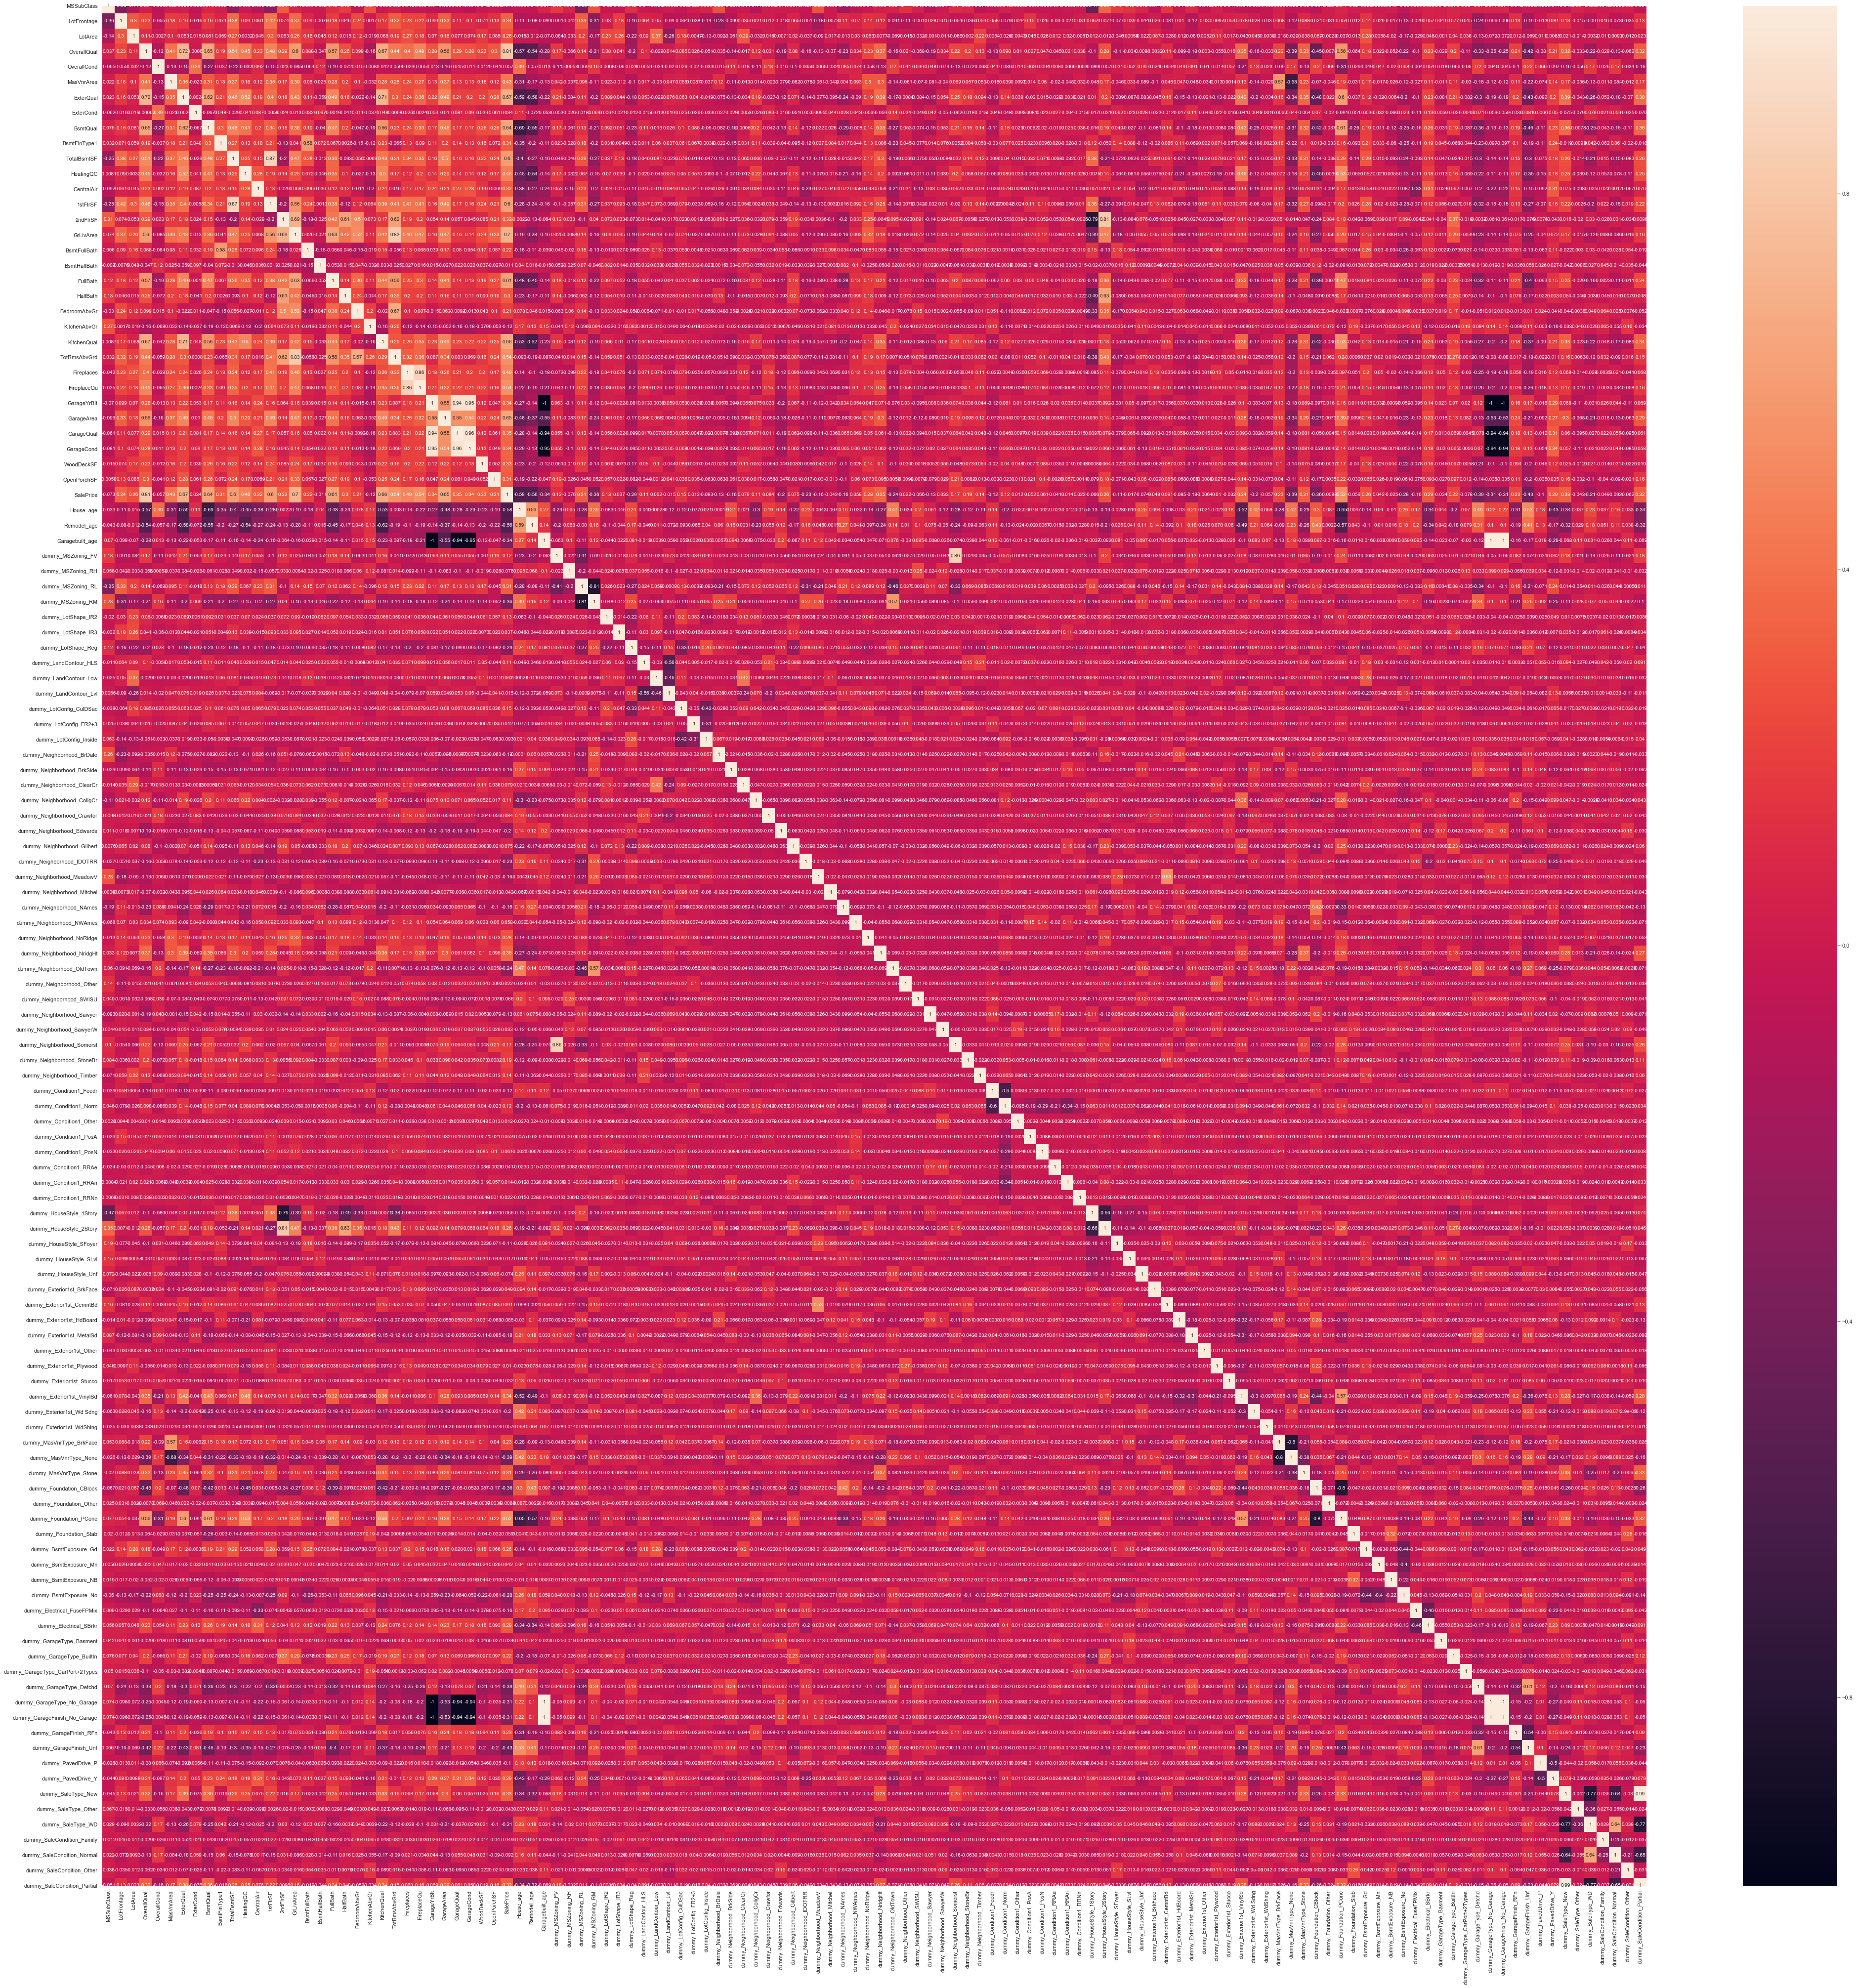

In [56]:
# Let's plot the correlation heatmap to analyse the correlation of different variables with the target
# We observe that their exist correlation as depicted in the heatmap but it's very dense due to the huge nb. of cols
plt.figure(figsize = (70,70))
sns.heatmap(master_df.corr(),annot = True)
plt.show()

## Step 5: Model Building and Evaluation

In [57]:
# Splitting the master dataframe into training and testing set.
# The first basic step for regression model building is performing a train-test split.
# Specify this so that the train and test data set always have the same rows using seed, respectively
np.random.seed(0)
df_train, df_test = train_test_split(master_df, train_size = 0.7, test_size = 0.3, random_state = 100)
print('df_train shape:', df_train.shape)
print('df_test shape:', df_test.shape)

df_train shape: (993, 124)
df_test shape: (426, 124)


In [58]:
# Training dataset has 993 rows and 123 columns
df_train.head()

MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond  MasVnrArea  \
975          160         69.0     2651            7            5         0.0   
1459          20         75.0     9937            5            6         0.0   
125          190         60.0     6780            6            8         0.0   
684           60         58.0    16770            7            5        30.0   
1316          20         61.0    10226            8            5       270.0   

      ExterQual  ExterCond  BsmtQual  BsmtFinType1  ...  \
975           4          3         4             5  ...   
1459          4          3         3             3  ...   
125           3          2         3             5  ...   
684           4          3         4             0  ...   
1316          4          3         5             0  ...   

      dummy_GarageFinish_Unf  dummy_PavedDrive_P  dummy_PavedDrive_Y  \
975                        1                   0                   1   
1459                       0                   0                   1   
125                        0                   0                   0   
684                        0                   0                   1   
1316                       0                   0                   1   

      dummy_SaleType_New  dummy_SaleType_Other  dummy_SaleType_WD  \
975                    0                     0                  1   
1459                   0                     0                  1   
125                    0                     0                  1   
684                    0                     0                  1   
1316                   0                     0                  1   

      dummy_SaleCondition_Family  dummy_SaleCondition_Normal  \
975                            0                           1   
1459                           0                           1   
125                            0                           1   
684                            0                           1   
1316                           0                           1   

      dummy_SaleCondition_Other  dummy_SaleCondition_Partial  
975                           0                            0  
1459                          0                            0  
125                           0                            0  
684                           0                            0  
1316                          0                            0  

[5 rows x 124 columns]

In [59]:
# Test dataset has 426 rows and 123 columns
df_test.head()

MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond  MasVnrArea  \
1310          20        100.0    17500            7            8         0.0   
692           60         42.0    26178            7            5       293.0   
414           60         59.0    11228            7            5         0.0   
422           20        100.0    21750            5            5         0.0   
1451          20         78.0     9262            8            5       194.0   

      ExterQual  ExterCond  BsmtQual  BsmtFinType1  ...  \
1310          4          4         4             5  ...   
692           4          3         4             5  ...   
414           4          3         4             3  ...   
422           3          3         3             0  ...   
1451          4          3         4             0  ...   

      dummy_GarageFinish_Unf  dummy_PavedDrive_P  dummy_PavedDrive_Y  \
1310                       0                   0                   1   
692                        0                   0                   1   
414                        1                   0                   1   
422                        0                   0                   0   
1451                       0                   0                   1   

      dummy_SaleType_New  dummy_SaleType_Other  dummy_SaleType_WD  \
1310                   0                     0                  1   
692                    0                     0                  1   
414                    0                     0                  1   
422                    0                     0                  1   
1451                   1                     0                  0   

      dummy_SaleCondition_Family  dummy_SaleCondition_Normal  \
1310                           0                           1   
692                            0                           1   
414                            0                           1   
422                            0                           1   
1451                           0                           0   

      dummy_SaleCondition_Other  dummy_SaleCondition_Partial  
1310                          0                            0  
692                           0                            0  
414                           0                            0  
422                           0                            0  
1451                          0                            1  

[5 rows x 124 columns]

In [60]:
# MinMax Scaling
# Observe that quantitative columns are in different range of values, so we should rescale
# Applying MinMax scaling to all the columns except the binary and dummy variables
scaler = MinMaxScaler()
df_train[saleprice_quant_df.columns] = scaler.fit_transform(df_train[saleprice_quant_df.columns])
df_train[saleprice_quant_df.columns].head()

MSSubClass  LotFrontage   LotArea  OverallQual  OverallCond  MasVnrArea  \
975     0.823529     0.164384  0.006315        0.625     0.428571     0.00000   
1459    0.000000     0.184932  0.040370        0.375     0.571429     0.00000   
125     1.000000     0.133562  0.025614        0.500     0.857143     0.00000   
684     0.235294     0.126712  0.072308        0.625     0.428571     0.01875   
1316    0.000000     0.136986  0.041721        0.750     0.428571     0.16875   

      ExterQual  ExterCond  BsmtQual  BsmtFinType1  ...  GarageYrBlt  \
975    0.666667   0.333333       0.8      1.000000  ...     0.995025   
1459   0.666667   0.333333       0.6      0.666667  ...     0.977612   
125    0.333333   0.000000       0.6      1.000000  ...     0.000000   
684    0.666667   0.333333       0.8      0.166667  ...     0.994030   
1316   0.666667   0.333333       1.0      0.166667  ...     0.999005   

      GarageArea  GarageQual  GarageCond  WoodDeckSF  OpenPorchSF  SalePrice  \
975     0.345557         0.6         0.6    0.178530     0.091408   0.505316   
1459    0.194640         0.6         0.6    0.858810     0.124314   0.468846   
125     0.000000         0.0         0.0    0.061844     0.000000   0.287638   
684     0.342736         0.6         0.6    0.000000     0.148080   0.600370   
1316    0.606488         0.6         0.6    0.200700     0.076782   0.694859   

      House_age  Remodel_age  Garagebuilt_age  
975    0.072464     0.166667         0.004975  
1459   0.326087     0.750000         0.022388  
125    0.543478     0.466667         1.000000  
684    0.086957     0.200000         0.005970  
1316   0.014493     0.033333         0.000995  

[5 rows x 36 columns]

In [61]:
# Observe statistics describe of training dataframe, scaling has been successfuly performed.
df_train.describe()

MSSubClass  LotFrontage     LotArea  OverallQual  OverallCond  \
count  993.000000   993.000000  993.000000   993.000000   993.000000   
mean     0.224690     0.166260    0.043772     0.521400     0.515465   
std      0.255890     0.079542    0.054582     0.166919     0.160529   
min      0.000000     0.000000    0.000000     0.000000     0.000000   
25%      0.000000     0.133562    0.028741     0.375000     0.428571   
50%      0.176471     0.164384    0.037626     0.500000     0.428571   
75%      0.294118     0.195205    0.047924     0.625000     0.571429   
max      1.000000     1.000000    1.000000     1.000000     1.000000   

       MasVnrArea   ExterQual   ExterCond    BsmtQual  BsmtFinType1  ...  \
count  993.000000  993.000000  993.000000  993.000000    993.000000  ...   
mean     0.063956    0.472306    0.363880    0.712790      0.602048  ...   
std      0.110141    0.191496    0.113326    0.147313      0.347310  ...   
min      0.000000    0.000000    0.000000    0.000000      0.000000  ...   
25%      0.000000    0.333333    0.333333    0.600000      0.166667  ...   
50%      0.000000    0.333333    0.333333    0.800000      0.666667  ...   
75%      0.103125    0.666667    0.333333    0.800000      1.000000  ...   
max      1.000000    1.000000    1.000000    1.000000      1.000000  ...   

       dummy_GarageFinish_Unf  dummy_PavedDrive_P  dummy_PavedDrive_Y  \
count              993.000000          993.000000          993.000000   
mean                 0.408862            0.017120            0.926485   
std                  0.491871            0.129783            0.261111   
min                  0.000000            0.000000            0.000000   
25%                  0.000000            0.000000            1.000000   
50%                  0.000000            0.000000            1.000000   
75%                  1.000000            0.000000            1.000000   
max                  1.000000            1.000000            1.000000   

       dummy_SaleType_New  dummy_SaleType_Other  dummy_SaleType_WD  \
count          993.000000            993.000000         993.000000   
mean             0.089627              0.020141           0.864048   
std              0.285791              0.140553           0.342910   
min              0.000000              0.000000           0.000000   
25%              0.000000              0.000000           1.000000   
50%              0.000000              0.000000           1.000000   
75%              0.000000              0.000000           1.000000   
max              1.000000              1.000000           1.000000   

       dummy_SaleCondition_Family  dummy_SaleCondition_Normal  \
count                  993.000000                  993.000000   
mean                     0.014099                    0.818731   
std                      0.117957                    0.385435   
min                      0.000000                    0.000000   
25%                      0.000000                    1.000000   
50%                      0.000000                    1.000000   
75%                      0.000000                    1.000000   
max                      1.000000                    1.000000   

       dummy_SaleCondition_Other  dummy_SaleCondition_Partial  
count                 993.000000                   993.000000  
mean                    0.011078                     0.090634  
std                     0.104718                     0.287233  
min                     0.000000                     0.000000  
25%                     0.000000                     0.000000  
50%                     0.000000                     0.000000  
75%                     0.000000                     0.000000  
max                     1.000000                     1.000000  

[8 rows x 124 columns]

In [62]:
# MinMax Scaling for df_test
# Observe that quantitative columns are in different range of values, so we should rescale
# Applying MinMax scaling to all the columns except the binary and dummy variables
df_test[saleprice_quant_df.columns] = scaler.transform(df_test[saleprice_quant_df.columns])
df_test[saleprice_quant_df.columns].head()

MSSubClass  LotFrontage   LotArea  OverallQual  OverallCond  MasVnrArea  \
1310    0.000000     0.270548  0.075720        0.625     0.857143    0.000000   
692     0.235294     0.071918  0.116282        0.625     0.428571    0.183125   
414     0.235294     0.130137  0.046404        0.625     0.428571    0.000000   
422     0.000000     0.270548  0.095585        0.375     0.428571    0.000000   
1451    0.000000     0.195205  0.037215        0.750     0.428571    0.121250   

      ExterQual  ExterCond  BsmtQual  BsmtFinType1  ...  GarageYrBlt  \
1310   0.666667   0.666667       0.8      1.000000  ...     0.974627   
692    0.666667   0.333333       0.8      1.000000  ...     0.989552   
414    0.666667   0.333333       0.8      0.666667  ...     0.991542   
422    0.333333   0.333333       0.6      0.166667  ...     0.972139   
1451   0.666667   0.333333       0.8      0.166667  ...     0.999005   

      GarageArea  GarageQual  GarageCond  WoodDeckSF  OpenPorchSF  SalePrice  \
1310    0.399859         0.6         0.6    0.000000     0.378428   0.735678   
692     0.442877         0.6         0.6    0.373396     0.049360   0.735678   
414     0.478138         0.6         0.6    0.228705     0.341865   0.610513   
422     0.366714         0.6         0.6    0.000000     0.000000   0.382177   
1451    0.592384         0.6         0.6    0.000000     0.065814   0.685475   

      House_age  Remodel_age  Garagebuilt_age  
1310   0.369565     0.133333         0.025373  
692    0.152174     0.333333         0.010448  
414    0.123188     0.283333         0.008458  
422    0.405797     0.933333         0.027861  
1451   0.014493     0.016667         0.000995  

[5 rows x 36 columns]

In [63]:
# Ready to divide the training and test dataframe into X and y datasets for the model building
# Got ready X_train, y_train, X_test and y_test for model building & evaluation
y_train = df_train.pop('SalePrice')
X_train = df_train
print('shape of X_train:\t', X_train.shape)

# Ready to divide the training dataframe into X and y datasets for the model building
# Got ready X_train and y_train for model building
y_test = df_test.pop('SalePrice')
X_test = df_test
print('shape of X_test:\t', X_test.shape)

shape of X_train:	 (993, 123)
shape of X_test:	 (426, 123)


### Model 1: Multiple Linear Regression Model - Using All the Parameters

In [64]:
# Creating a LinearRegression model object importing from sklearn.linear_model package & fit it with X_train & y_train
# Next we calculate the R2 score of this first basic model on the training set by using predict function
# Next we calculate the R2 score of this first basic model on the test set by using predict function
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

y_train_pred = lr_model.predict(X_train)
print("R2 for Linear Regression Model on training set:\t", r2_score(y_true=y_train, y_pred=y_train_pred))

y_test_pred = lr_model.predict(X_test)
print("R2 for Linear Regression Model on test set:\t", r2_score(y_true=y_test, y_pred=y_test_pred))

R2 for Linear Regression Model on training set:	 0.9133366606089443
R2 for Linear Regression Model on test set:	 0.8711859635045032


In [65]:
# Find the list of feature along with it's coefficient values
lr_model_features = list(lr_model.coef_)
lr_model_features.insert(0, lr_model.intercept_)
lr_model_features = [round(x, 2) for x in lr_model_features]
lr_model_cols = X_train.columns
lr_model_cols = lr_model_cols.insert(0, "constant")
list(zip(lr_model_cols, lr_model_features))

[('constant', 1568658228349.68),
 ('MSSubClass', -0.04),
 ('LotFrontage', -0.07),
 ('LotArea', 0.08),
 ('OverallQual', 0.14),
 ('OverallCond', 0.09),
 ('MasVnrArea', -0.01),
 ('ExterQual', -0.01),
 ('ExterCond', -0.01),
 ('BsmtQual', 0.07),
 ('BsmtFinType1', 0.02),
 ('TotalBsmtSF', -0.08),
 ('HeatingQC', 0.02),
 ('CentralAir', 0.01),
 ('1stFlrSF', 0.22),
 ('2ndFlrSF', 0.1),
 ('GrLivArea', 0.11),
 ('BsmtFullBath', 0.03),
 ('BsmtHalfBath', 0.01),
 ('FullBath', 0.02),
 ('HalfBath', 0.03),
 ('BedroomAbvGr', 0.03),
 ('KitchenAbvGr', 0.01),
 ('KitchenQual', 0.03),
 ('TotRmsAbvGrd', 0.07),
 ('Fireplaces', 0.0),
 ('FireplaceQu', 0.02),
 ('GarageYrBlt', -1568658228349.83),
 ('GarageArea', 0.08),
 ('GarageQual', 0.08),
 ('GarageCond', -0.01),
 ('WoodDeckSF', 0.01),
 ('OpenPorchSF', 0.02),
 ('House_age', -0.04),
 ('Remodel_age', -0.01),
 ('Garagebuilt_age', -1568658228349.33),
 ('dummy_MSZoning_FV', 0.17),
 ('dummy_MSZoning_RH', 0.19),
 ('dummy_MSZoning_RL', 0.18),
 ('dummy_MSZoning_RM', 0.16),
 

In [66]:
# Find all the relevant features obtained from the Multiple linear regression model
# So we observe that multiple linear regression chooses 101 features among the total 123 columns
parameter_df = pd.DataFrame()
parameter_df = pd.Series(lr_model_cols).to_frame()
parameter_df.columns = ['Features']
parameter_df['weight'] = pd.Series(lr_model_features)
print('Number of features selected by Multiple linear regression:', len(parameter_df[parameter_df['weight']!=0]))
parameter_df[parameter_df['weight']!=0].sort_values(by='weight', ascending=False)

Number of features selected by Multiple linear regression: 103


Features        weight
0                        constant  1.568658e+12
111    dummy_GarageType_No_Garage  5.661234e+11
14                       1stFlrSF  2.200000e-01
37              dummy_MSZoning_RH  1.900000e-01
38              dummy_MSZoning_RL  1.800000e-01
..                            ...           ...
2                     LotFrontage -7.000000e-02
11                    TotalBsmtSF -8.000000e-02
112  dummy_GarageFinish_No_Garage -5.661234e+11
35                Garagebuilt_age -1.568658e+12
27                    GarageYrBlt -1.568658e+12

[103 rows x 2 columns]

### Model 2: Advanced Regression Model - Lasso

In [67]:
# Creating an Advanced Regression model using Lasso & fit it with X_train & y_train using gridsearch cross validation
# Next we analyse the gridsearch cross validation results
cv_folds = 5
alpha_parameters = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0,
                              2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000, 1500]}
lasso_model = Lasso()
gridsearch_cv_model = GridSearchCV(estimator = lasso_model,
                                   param_grid = alpha_parameters,
                                   scoring= 'r2', cv = cv_folds,
                                   return_train_score=True,
                                   verbose = 1)            
gridsearch_cv_model.fit(X_train, y_train)

gridsearch_cv_model_results = pd.DataFrame(gridsearch_cv_model.cv_results_)
gridsearch_cv_model_results.head()

Fitting 5 folds for each of 29 candidates, totalling 145 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 145 out of 145 | elapsed:    0.9s finished


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha  \
0       0.019741      0.008681         0.001272        0.000197      0.0001   
1       0.008674      0.004815         0.001143        0.000064       0.001   
2       0.003365      0.000240         0.001098        0.000119        0.01   
3       0.002820      0.000331         0.000995        0.000118        0.05   
4       0.002806      0.000133         0.001030        0.000052         0.1   

              params  split0_test_score  split1_test_score  split2_test_score  \
0  {'alpha': 0.0001}           0.901737           0.888276           0.877548   
1   {'alpha': 0.001}           0.861710           0.830094           0.848323   
2    {'alpha': 0.01}           0.491694           0.446185           0.490866   
3    {'alpha': 0.05}          -0.010118          -0.001024          -0.001367   
4     {'alpha': 0.1}          -0.010118          -0.001024          -0.001367   

   split3_test_score  ...  mean_test_score  std_test_score  rank_test_score  \
0           0.888375  ...         0.858052        0.062456                1   
1           0.857826  ...         0.832278        0.036157                2   
2           0.491456  ...         0.483859        0.019107                3   
3          -0.014525  ...        -0.005515        0.005728                4   
4          -0.014525  ...        -0.005515        0.005728                4   

   split0_train_score  split1_train_score  split2_train_score  \
0            0.905021            0.905206            0.911512   
1            0.851845            0.854304            0.855390   
2            0.474223            0.526758            0.476399   
3            0.000000            0.000000            0.000000   
4            0.000000            0.000000            0.000000   

   split3_train_score  split4_train_score  mean_train_score  std_train_score  
0            0.908252            0.925946          0.911187         0.007750  
1            0.853874            0.879287          0.858940         0.010238  
2            0.500332            0.509791          0.497501         0.020011  
3            0.000000            0.000000          0.000000         0.000000  
4            0.000000            0.000000          0.000000         0.000000  

[5 rows x 21 columns]

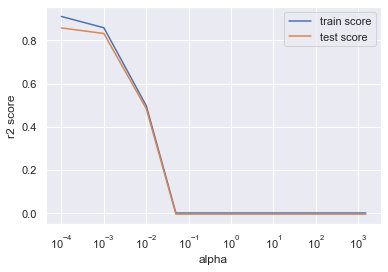

In [68]:
# Plot the alpha and the r2 score for the mean train and test score comparisons
# Visualise the observe how train and test r2 score vary and strong indicator of good model
gridsearch_cv_model_results['param_alpha'] = gridsearch_cv_model_results['param_alpha'].astype('float32')
plt.plot(gridsearch_cv_model_results['param_alpha'], gridsearch_cv_model_results['mean_train_score'])
plt.plot(gridsearch_cv_model_results['param_alpha'], gridsearch_cv_model_results['mean_test_score'])
plt.legend(['train score', 'test score'], loc='best')
plt.xlabel('alpha')
plt.ylabel('r2 score')
plt.xscale('log')
plt.show()

In [69]:
# Creating a Lasso model object and then using optimal alpha value of 0.0001 fit it with X_train & y_train
# Next we calculate the R2 score of this first basic model on the training set by using predict function
# Next we calculate the R2 score of this first basic model on the test set by using predict function
# We observe that it seems as a decent model with r2 score of 0.88 on unseen test data using Lasso Regression
print('Best alpha value obtained after cross validation:', gridsearch_cv_model.best_params_)
lasso_model = Lasso(alpha=0.0001)
lasso_model.fit(X_train, y_train)

y_train_pred = lasso_model.predict(X_train)
print("R2 for Lasso Model on training set:\t", r2_score(y_true=y_train, y_pred=y_train_pred))

y_test_pred = lasso_model.predict(X_test)
print("R2 for Lasso Model on test set:\t\t", r2_score(y_true=y_test, y_pred=y_test_pred))

Best alpha value obtained after cross validation: {'alpha': 0.0001}
R2 for Lasso Model on training set:	 0.9064489868525168
R2 for Lasso Model on test set:		 0.8893806715373093


In [70]:
# Get the model paramter coefficients, we observe that few features have the coefficient as zero
lasso_model.coef_

array([-0.03415658, -0.01725046,  0.02835126,  0.15275059,  0.08744051,
       -0.        , -0.        , -0.        ,  0.0535903 ,  0.01944141,
        0.        ,  0.02006705,  0.01663794,  0.        ,  0.        ,
        0.27997738,  0.02898269,  0.        ,  0.03013783,  0.02353215,
        0.01807609,  0.        ,  0.02756911,  0.08471096,  0.00138077,
        0.02346943,  0.        ,  0.06177721,  0.05372948,  0.        ,
        0.01324872,  0.00096488, -0.02641658, -0.01005079, -0.        ,
        0.05957993,  0.07538865,  0.07254156,  0.04852662,  0.00950071,
       -0.02359337,  0.        ,  0.01409744,  0.03069758,  0.01330826,
        0.01350795, -0.00504571, -0.00250912, -0.00656519,  0.01623735,
        0.03772344,  0.00142656,  0.04174509, -0.02126129, -0.        ,
       -0.02232654, -0.02645305, -0.00046288, -0.0031819 , -0.00052573,
        0.03535402,  0.03852303, -0.00161738,  0.01256341, -0.        ,
       -0.        ,  0.        ,  0.03773526,  0.05129759,  0.01

In [71]:
# Find out the lasso model feature parameters
lasso_model_features = list(lasso_model.coef_)
lasso_model_features.insert(0, lasso_model.intercept_)
lasso_model_features = [round(x, 3) for x in lasso_model_features]
lasso_model_cols = X_train.columns
lasso_model_cols = lasso_model_cols.insert(0, "constant")
list(zip(lasso_model_cols, lasso_model_features))

[('constant', -0.002),
 ('MSSubClass', -0.034),
 ('LotFrontage', -0.017),
 ('LotArea', 0.028),
 ('OverallQual', 0.153),
 ('OverallCond', 0.087),
 ('MasVnrArea', -0.0),
 ('ExterQual', -0.0),
 ('ExterCond', -0.0),
 ('BsmtQual', 0.054),
 ('BsmtFinType1', 0.019),
 ('TotalBsmtSF', 0.0),
 ('HeatingQC', 0.02),
 ('CentralAir', 0.017),
 ('1stFlrSF', 0.0),
 ('2ndFlrSF', 0.0),
 ('GrLivArea', 0.28),
 ('BsmtFullBath', 0.029),
 ('BsmtHalfBath', 0.0),
 ('FullBath', 0.03),
 ('HalfBath', 0.024),
 ('BedroomAbvGr', 0.018),
 ('KitchenAbvGr', 0.0),
 ('KitchenQual', 0.028),
 ('TotRmsAbvGrd', 0.085),
 ('Fireplaces', 0.001),
 ('FireplaceQu', 0.023),
 ('GarageYrBlt', 0.0),
 ('GarageArea', 0.062),
 ('GarageQual', 0.054),
 ('GarageCond', 0.0),
 ('WoodDeckSF', 0.013),
 ('OpenPorchSF', 0.001),
 ('House_age', -0.026),
 ('Remodel_age', -0.01),
 ('Garagebuilt_age', -0.0),
 ('dummy_MSZoning_FV', 0.06),
 ('dummy_MSZoning_RH', 0.075),
 ('dummy_MSZoning_RL', 0.073),
 ('dummy_MSZoning_RM', 0.049),
 ('dummy_LotShape_IR2', 

In [72]:
# Find all the relevant features obtained from the Lasso regression model
# To remind, Lasso assigns a model parameter weight of zero in case of parameter is insignificant
# So we observe that Lasso regression chooses 82 features among the total 123 columns
parameter_df = pd.DataFrame()
parameter_df = pd.Series(lasso_model_cols).to_frame()
parameter_df.columns = ['Features']
parameter_df['weight'] = pd.Series(lasso_model_features)
print('Number of features selected by Lasso regression:', len(parameter_df[parameter_df['weight']!=0]))
parameter_df[parameter_df['weight']!=0].sort_values(by='weight', ascending=False)

Number of features selected by Lasso regression: 84


Features  weight
16                   GrLivArea   0.280
4                  OverallQual   0.153
5                  OverallCond   0.087
24                TotRmsAbvGrd   0.085
37           dummy_MSZoning_RH   0.075
..                         ...     ...
41          dummy_LotShape_IR3  -0.024
57  dummy_Neighborhood_MeadowV  -0.026
33                   House_age  -0.026
90    dummy_Exterior1st_Stucco  -0.028
1                   MSSubClass  -0.034

[84 rows x 2 columns]

### Model 3: Advanced Regression Model - Ridge

In [73]:
# Creating an Advanced Regression model using Ridge & fit it with X_train & y_train using gridsearch cross validation
# Next we analyse the gridsearch cross validation results
ridge_model = Ridge()
gridsearch_cv_model = GridSearchCV(estimator = ridge_model,
                                   param_grid = alpha_parameters,
                                   scoring= 'r2', cv = cv_folds,
                                   return_train_score=True,
                                   verbose = 1)            
gridsearch_cv_model.fit(X_train, y_train)

gridsearch_cv_model_results = pd.DataFrame(gridsearch_cv_model.cv_results_)
gridsearch_cv_model_results.head()

Fitting 5 folds for each of 29 candidates, totalling 145 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 145 out of 145 | elapsed:    0.9s finished


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha  \
0       0.003524      0.001303         0.001060        0.000060      0.0001   
1       0.003173      0.000275         0.001211        0.000189       0.001   
2       0.003538      0.000205         0.001225        0.000042        0.01   
3       0.003471      0.000259         0.001191        0.000127        0.05   
4       0.003107      0.000262         0.001020        0.000123         0.1   

              params  split0_test_score  split1_test_score  split2_test_score  \
0  {'alpha': 0.0001}           0.881938           0.888893           0.868335   
1   {'alpha': 0.001}           0.883083           0.888873           0.868360   
2    {'alpha': 0.01}           0.888699           0.888657           0.868552   
3    {'alpha': 0.05}           0.893052           0.888086           0.869290   
4     {'alpha': 0.1}           0.894257           0.887726           0.870130   

   split3_test_score  ...  mean_test_score  std_test_score  rank_test_score  \
0           0.880555  ...         0.847161        0.065995               23   
1           0.880547  ...         0.847386        0.066122               22   
2           0.880549  ...         0.848508        0.066750               21   
3           0.881260  ...         0.849810        0.066831               20   
4           0.882280  ...         0.850761        0.066278               19   

   split0_train_score  split1_train_score  split2_train_score  \
0            0.913313            0.912492            0.919337   
1            0.913307            0.912491            0.919337   
2            0.913076            0.912447            0.919294   
3            0.912377            0.912242            0.919081   
4            0.911980            0.912063            0.918857   

   split3_train_score  split4_train_score  mean_train_score  std_train_score  
0            0.915807            0.932297          0.918649         0.007228  
1            0.915807            0.932297          0.918648         0.007229  
2            0.915780            0.932270          0.918574         0.007262  
3            0.915625            0.932138          0.918293         0.007363  
4            0.915421            0.932013          0.918067         0.007419  

[5 rows x 21 columns]

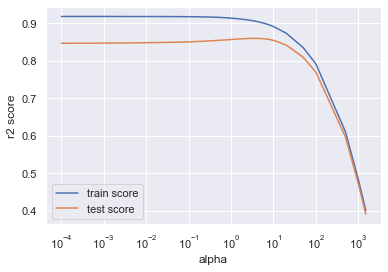

In [74]:
# Plot the alpha and the r2 score for the mean train and test score comparisons
# Visualise the observe how train and test r2 score vary and strong indicator of good model
gridsearch_cv_model_results['param_alpha'] = gridsearch_cv_model_results['param_alpha'].astype('float32')
plt.plot(gridsearch_cv_model_results['param_alpha'], gridsearch_cv_model_results['mean_train_score'])
plt.plot(gridsearch_cv_model_results['param_alpha'], gridsearch_cv_model_results['mean_test_score'])
plt.legend(['train score', 'test score'], loc='best')
plt.xlabel('alpha')
plt.ylabel('r2 score')
plt.xscale('log')
plt.show()

In [75]:
# Creating a Ridge model object and then using optimal alpha value of 6 fit it with X_train & y_train
# Next we calculate the R2 score of this first basic model on the training set by using predict function
# Next we calculate the R2 score of this first basic model on the test set by using predict function
# We observe that it seems as a decent model with r2 score of 0.88 on unseen test data using ridge Regression
print('Best alpha value obtained in ridge regression after cross validation:', gridsearch_cv_model.best_params_)
ridge_model = Ridge(alpha=4)
ridge_model.fit(X_train, y_train)

y_train_pred = ridge_model.predict(X_train)
print("R2 for Ridge Model on training set:\t", r2_score(y_true=y_train, y_pred=y_train_pred))

y_test_pred = ridge_model.predict(X_test)
print("R2 for Ridge Model on test set:\t\t", r2_score(y_true=y_test, y_pred=y_test_pred))

Best alpha value obtained in ridge regression after cross validation: {'alpha': 4.0}
R2 for Ridge Model on training set:	 0.9029842857639991
R2 for Ridge Model on test set:		 0.8875891383183165


In [76]:
# Find out the ridge model feature parameters
ridge_model_features = list(ridge_model.coef_)
ridge_model_features.insert(0, ridge_model.intercept_)
ridge_model_features = [round(x, 2) for x in ridge_model_features]
ridge_model_cols = X_train.columns
ridge_model_cols = ridge_model_cols.insert(0, "constant")
list(zip(ridge_model_cols, ridge_model_features))

[('constant', 0.05),
 ('MSSubClass', -0.04),
 ('LotFrontage', -0.01),
 ('LotArea', 0.03),
 ('OverallQual', 0.12),
 ('OverallCond', 0.07),
 ('MasVnrArea', 0.01),
 ('ExterQual', 0.0),
 ('ExterCond', -0.0),
 ('BsmtQual', 0.05),
 ('BsmtFinType1', 0.02),
 ('TotalBsmtSF', 0.03),
 ('HeatingQC', 0.02),
 ('CentralAir', 0.02),
 ('1stFlrSF', 0.08),
 ('2ndFlrSF', 0.06),
 ('GrLivArea', 0.09),
 ('BsmtFullBath', 0.03),
 ('BsmtHalfBath', 0.0),
 ('FullBath', 0.04),
 ('HalfBath', 0.03),
 ('BedroomAbvGr', 0.04),
 ('KitchenAbvGr', 0.01),
 ('KitchenQual', 0.03),
 ('TotRmsAbvGrd', 0.08),
 ('Fireplaces', 0.01),
 ('FireplaceQu', 0.02),
 ('GarageYrBlt', 0.0),
 ('GarageArea', 0.06),
 ('GarageQual', 0.03),
 ('GarageCond', 0.01),
 ('WoodDeckSF', 0.02),
 ('OpenPorchSF', 0.01),
 ('House_age', -0.01),
 ('Remodel_age', -0.02),
 ('Garagebuilt_age', -0.0),
 ('dummy_MSZoning_FV', 0.03),
 ('dummy_MSZoning_RH', 0.04),
 ('dummy_MSZoning_RL', 0.04),
 ('dummy_MSZoning_RM', 0.02),
 ('dummy_LotShape_IR2', 0.01),
 ('dummy_LotSh

In [77]:
# Find all the top features obtained from the Ridge regression model
# So we observe that Ridge regression chooses 123 features
# List of top features obtained from the Ridge regression
parameter_df = pd.DataFrame()
parameter_df = pd.Series(ridge_model_cols).to_frame()
parameter_df.columns = ['Features']
parameter_df['weight'] = pd.Series(ridge_model_features)
print('Number of features selected by Ridge regression:', parameter_df.shape[0])
parameter_df.sort_values(by='weight', ascending=False).head()

Number of features selected by Ridge regression: 124


Features  weight
4    OverallQual    0.12
16     GrLivArea    0.09
24  TotRmsAbvGrd    0.08
14      1stFlrSF    0.08
5    OverallCond    0.07

## Step 6: Rebuilding Models after Reprocessing Data
### Revisiting Step 2: Data Understanding and Cleaning
#### Approach 2 (In this approach we will refrain from dropping excessive columns or too much data cleaning)

In [78]:
# Read assignment data train.csv dataset into a dataframe and drop duplicates, if any
saleprice_df = pd.read_csv('train.csv')
print(saleprice_df.shape)
saleprice_df = saleprice_df.drop_duplicates()
saleprice_df.shape

(1460, 81)


(1460, 81)

In [79]:
# Let's do some cleaning, drop columns having only one unique value
# and the ones with high missing value percentage and create some basic derived features
# Also dropping rows were we have NaNs at row wise
saleprice_df.drop(['Id'], axis=1, inplace=True)
uniques = saleprice_df.apply(lambda x:x.nunique())
saleprice_df = saleprice_df.drop(uniques[uniques < 2].index, axis = 1)
saleprice_df.drop(['Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature', 'LotFrontage'], axis=1, inplace=True)
saleprice_df.dropna(axis='rows', inplace=True)
saleprice_df['DiffYearBuilt'] = pd.datetime.now().year - saleprice_df['YearBuilt']
saleprice_df['DiffYearRemodAdd'] = pd.datetime.now().year - saleprice_df['YearRemodAdd']
saleprice_df['DiffGarageYrBlt'] = pd.datetime.now().year - saleprice_df['GarageYrBlt']
saleprice_df.drop(['YearBuilt', 'YearRemodAdd', 'GarageYrBlt'], axis=1, inplace=True)
saleprice_df.shape

(1338, 74)

In [80]:
# Create a new dataframe which contains categorical variables.
print("shape of original df:", saleprice_df.shape)
saleprice_cat_df = saleprice_df.select_dtypes(exclude=np.number)
print("shape of categorical df:", saleprice_cat_df.shape)

# Create a new dataframe which contains numeric variables.
saleprice_quant_df = saleprice_df.select_dtypes(include=np.number)
print("shape of quantitative df:", saleprice_quant_df.shape)

shape of original df: (1338, 74)
shape of categorical df: (1338, 38)
shape of quantitative df: (1338, 36)


In [81]:
# Create dummy variables for the categorical columns
for col in saleprice_cat_df.columns:
    dummies = pd.get_dummies(saleprice_df[col], drop_first = True)
    dummies = dummies.add_prefix(f'{col}_')
    saleprice_df = pd.concat([saleprice_df, dummies], axis = 1)
    saleprice_df.drop([col], axis = 1, inplace = True)
print(saleprice_df.shape)
saleprice_df.head()

(1338, 227)


MSSubClass  LotArea  OverallQual  OverallCond  MasVnrArea  BsmtFinSF1  \
0          60     8450            7            5       196.0         706   
1          20     9600            6            8         0.0         978   
2          60    11250            7            5       162.0         486   
3          70     9550            7            5         0.0         216   
4          60    14260            8            5       350.0         655   

   BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  1stFlrSF  ...  SaleType_ConLI  \
0           0        150          856       856  ...               0   
1           0        284         1262      1262  ...               0   
2           0        434          920       920  ...               0   
3           0        540          756       961  ...               0   
4           0        490         1145      1145  ...               0   

   SaleType_ConLw  SaleType_New  SaleType_Oth  SaleType_WD  \
0               0             0             0            1   
1               0             0             0            1   
2               0             0             0            1   
3               0             0             0            1   
4               0             0             0            1   

   SaleCondition_AdjLand  SaleCondition_Alloca  SaleCondition_Family  \
0                      0                     0                     0   
1                      0                     0                     0   
2                      0                     0                     0   
3                      0                     0                     0   
4                      0                     0                     0   

   SaleCondition_Normal  SaleCondition_Partial  
0                     1                      0  
1                     1                      0  
2                     1                      0  
3                     0                      0  
4                     1                      0  

[5 rows x 227 columns]

In [82]:
# Removing outliers greater or less than three times the Std. Deviation
from scipy import stats
z_scores = np.abs(stats.zscore(saleprice_df[saleprice_quant_df.columns]))
selected = saleprice_df[saleprice_quant_df.columns][(z_scores < 3).all(axis=1)]
saleprice_df = saleprice_df.loc[selected.index]
print(saleprice_df.shape)
saleprice_df.head()

(955, 227)


MSSubClass  LotArea  OverallQual  OverallCond  MasVnrArea  BsmtFinSF1  \
0           60     8450            7            5       196.0         706   
2           60    11250            7            5       162.0         486   
4           60    14260            8            5       350.0         655   
6           20    10084            8            5       186.0        1369   
10          20    11200            5            5         0.0         906   

    BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  1stFlrSF  ...  SaleType_ConLI  \
0            0        150          856       856  ...               0   
2            0        434          920       920  ...               0   
4            0        490         1145      1145  ...               0   
6            0        317         1686      1694  ...               0   
10           0        134         1040      1040  ...               0   

    SaleType_ConLw  SaleType_New  SaleType_Oth  SaleType_WD  \
0                0             0             0            1   
2                0             0             0            1   
4                0             0             0            1   
6                0             0             0            1   
10               0             0             0            1   

    SaleCondition_AdjLand  SaleCondition_Alloca  SaleCondition_Family  \
0                       0                     0                     0   
2                       0                     0                     0   
4                       0                     0                     0   
6                       0                     0                     0   
10                      0                     0                     0   

    SaleCondition_Normal  SaleCondition_Partial  
0                      1                      0  
2                      1                      0  
4                      1                      0  
6                      1                      0  
10                     1                      0  

[5 rows x 227 columns]

In [83]:
# Splitting the master dataframe into training and testing set.
# The first basic step for regression model building is performing a train-test split.
# Specify this so that the train and test data set always have the same rows using seed, respectively
y = saleprice_df.pop('SalePrice')
X = saleprice_df

np.random.seed(0)
scaler = StandardScaler()
scaler.fit(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, test_size = 0.3, random_state = 100)
print('X_train shape:\t', X_train.shape)
print('X_test shape:\t', X_test.shape)
print('y_train shape:\t', y_train.shape)
print('y_test shape:\t', y_test.shape)

X_train shape:	 (668, 226)
X_test shape:	 (287, 226)
y_train shape:	 (668,)
y_test shape:	 (287,)


### Model 1: Multiple Linear Regression Model - Using All the Parameters

In [84]:
# Creating a LinearRegression model object importing from sklearn.linear_model package & fit it with X_train & y_train
# Next we calculate the R2 score of this first basic model on the training set by using predict function
# Next we calculate the R2 score of this first basic model on the test set by using predict function
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

y_train_pred = lr_model.predict(X_train)
print("R2 for Linear Regression Model on training set:\t", r2_score(y_true=y_train, y_pred=y_train_pred))

y_test_pred = lr_model.predict(X_test)
print("R2 for Linear Regression Model on test set:\t", r2_score(y_true=y_test, y_pred=y_test_pred))

R2 for Linear Regression Model on training set:	 0.9490957438317392
R2 for Linear Regression Model on test set:	 0.9076802491359214


In [85]:
# Find the list of feature along with it's coefficient values
lr_model_features = list(lr_model.coef_)
lr_model_features.insert(0, lr_model.intercept_)
lr_model_features = [round(x, 2) for x in lr_model_features]
lr_model_cols = X_train.columns
lr_model_cols = lr_model_cols.insert(0, "constant")
list(zip(lr_model_cols, lr_model_features))

[('constant', 730203.6),
 ('MSSubClass', -156.83),
 ('LotArea', 1.19),
 ('OverallQual', 6233.67),
 ('OverallCond', 5262.73),
 ('MasVnrArea', -0.77),
 ('BsmtFinSF1', 22.59),
 ('BsmtFinSF2', 2.8),
 ('BsmtUnfSF', 1.97),
 ('TotalBsmtSF', 27.36),
 ('1stFlrSF', 19.6),
 ('2ndFlrSF', 56.17),
 ('LowQualFinSF', -48.3),
 ('GrLivArea', 27.47),
 ('BsmtFullBath', 280.35),
 ('BsmtHalfBath', 0.0),
 ('FullBath', -1796.6),
 ('HalfBath', -1239.3),
 ('BedroomAbvGr', 547.24),
 ('KitchenAbvGr', 0.0),
 ('TotRmsAbvGrd', -2714.06),
 ('Fireplaces', 2456.91),
 ('GarageCars', 4326.55),
 ('GarageArea', 19.57),
 ('WoodDeckSF', 26.76),
 ('OpenPorchSF', 31.39),
 ('EnclosedPorch', 24.83),
 ('3SsnPorch', -724.95),
 ('ScreenPorch', 40.9),
 ('PoolArea', 0.0),
 ('MiscVal', 5.72),
 ('MoSold', 339.18),
 ('YrSold', -381.48),
 ('DiffYearBuilt', -292.95),
 ('DiffYearRemodAdd', -179.64),
 ('DiffGarageYrBlt', 15.85),
 ('MSZoning_FV', 29032.43),
 ('MSZoning_RH', 21875.62),
 ('MSZoning_RL', 18458.06),
 ('MSZoning_RM', 14452.91),
 

In [86]:
# Find all the relevant features obtained from the Multiple linear regression model
# So we observe that Linear regression chooses 101 features among the total 226 columns
parameter_df = pd.DataFrame()
parameter_df = pd.Series(lr_model_cols).to_frame()
parameter_df.columns = ['Features']
parameter_df['weight'] = pd.Series(lr_model_features)
print('Number of features selected by Multiple linear regression:', len(parameter_df[parameter_df['weight']!=0]))
parameter_df[parameter_df['weight']!=0].sort_values(by='weight', ascending=False)

Number of features selected by Multiple linear regression: 203


Features     weight
0                 constant  730203.60
226  SaleCondition_Partial   40966.33
85         Condition1_RRNn   30584.05
36             MSZoning_FV   29032.43
205          GarageQual_Gd   28848.46
..                     ...        ...
219           SaleType_New  -30347.99
194         Functional_Mod  -31664.12
156        Foundation_Wood  -41162.31
116    Exterior1st_BrkComm  -42355.45
206          GarageQual_Po  -43785.88

[203 rows x 2 columns]

### Model 2: Advanced Regression Model - Lasso

In [87]:
# Creating an Advanced Regression model using Lasso & fit it with X_train & y_train using gridsearch cross validation
# Next we analyse the gridsearch cross validation results
# scoring as Negative Mean Absolute Error
cv_folds = 5
alpha_parameters = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0,
                              2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000, 1500]}
lasso_model = Lasso()
gridsearch_cv_model = GridSearchCV(estimator = lasso_model,
                                   param_grid = alpha_parameters,
                                   scoring= 'neg_mean_absolute_error', cv = cv_folds,
                                   return_train_score=True,
                                   verbose = 1)            
gridsearch_cv_model.fit(X_train, y_train)

gridsearch_cv_model_results = pd.DataFrame(gridsearch_cv_model.cv_results_)
gridsearch_cv_model_results.head()

Fitting 5 folds for each of 29 candidates, totalling 145 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 145 out of 145 | elapsed:   10.4s finished
/Users/ragesh/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha  \
0       0.080078      0.005563         0.001359        0.000095      0.0001   
1       0.081043      0.002848         0.001314        0.000118       0.001   
2       0.082954      0.005430         0.001470        0.000068        0.01   
3       0.078707      0.003175         0.001376        0.000085        0.05   
4       0.084821      0.005041         0.001603        0.000274         0.1   

              params  split0_test_score  split1_test_score  split2_test_score  \
0  {'alpha': 0.0001}      -16617.539157      -14338.961860      -13953.009826   
1   {'alpha': 0.001}      -16618.394627      -14338.982616      -13951.103568   
2    {'alpha': 0.01}      -16626.960449      -14339.189429      -13932.068387   
3    {'alpha': 0.05}      -16646.097983      -14340.272556      -13897.251931   
4     {'alpha': 0.1}      -16628.839961      -14340.525440      -13898.024321   

   split3_test_score  ...  mean_test_score  std_test_score  rank_test_score  \
0      -16787.970335  ...    -15731.324278     1308.327773               27   
1      -16784.087417  ...    -15730.339451     1308.331215               26   
2      -16764.130861  ...    -15724.254706     1311.441672               25   
3      -16651.294268  ...    -15698.864715     1306.420801               24   
4      -16529.174820  ...    -15671.366801     1286.710486               23   

   split0_train_score  split1_train_score  split2_train_score  \
0        -9076.469416        -9719.347446        -9433.041493   
1        -9076.472938        -9719.349707        -9433.067929   
2        -9076.517072        -9719.505132        -9433.336648   
3        -9076.651736        -9720.241442        -9434.542140   
4        -9076.839822        -9721.196769        -9436.045423   

   split3_train_score  split4_train_score  mean_train_score  std_train_score  
0        -8863.662324        -9168.012519      -9252.106640       296.600955  
1        -8863.656493        -9168.028430      -9252.115099       296.605101  
2        -8863.644105        -9168.248585      -9252.250308       296.672403  
3        -8863.704274        -9169.491650      -9252.926248       296.949694  
4        -8863.672677        -9171.216919      -9253.794322       297.323841  

[5 rows x 21 columns]

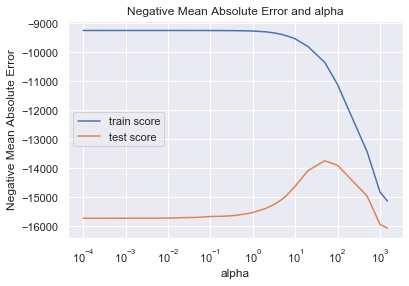

In [88]:
# Plot the alpha and the Negative Mean Absolute Error score for the mean train and test score comparisons
# Visualise the observe how train and test Negative Mean Absolute Error score vary and strong indicator of good model
gridsearch_cv_model_results['param_alpha'] = gridsearch_cv_model_results['param_alpha'].astype('float32')
plt.plot(gridsearch_cv_model_results['param_alpha'], gridsearch_cv_model_results['mean_train_score'])
plt.plot(gridsearch_cv_model_results['param_alpha'], gridsearch_cv_model_results['mean_test_score'])
plt.legend(['train score', 'test score'], loc='best')
plt.xlabel('alpha')
plt.ylabel('Negative Mean Absolute Error')
plt.title("Negative Mean Absolute Error and alpha")
plt.xscale('log')
plt.show()

In [89]:
# Creating a Lasso model object and then using optimal alpha value of 0.0001 fit it with X_train & y_train
# Next we calculate the R2 score of this first basic model on the training set by using predict function
# Next we calculate the R2 score of this first basic model on the test set by using predict function
# We observe that it seems as a decent model with r2 score of 0.88 on unseen test data using Lasso Regression
print('Best alpha value obtained after cross validation:', gridsearch_cv_model.best_params_)
lasso_model = Lasso(alpha=50)
lasso_model.fit(X_train, y_train)

y_train_pred = lasso_model.predict(X_train)
print("R2 for Lasso Model on training set:\t", r2_score(y_true=y_train, y_pred=y_train_pred))

y_test_pred = lasso_model.predict(X_test)
print("R2 for Lasso Model on test set:\t\t", r2_score(y_true=y_test, y_pred=y_test_pred))

Best alpha value obtained after cross validation: {'alpha': 50}
R2 for Lasso Model on training set:	 0.9408202494114437
R2 for Lasso Model on test set:		 0.9204604878066895


In [90]:
# Find out the lasso model feature parameters
lasso_model_features = list(lasso_model.coef_)
lasso_model_features.insert(0, lasso_model.intercept_)
lasso_model_features = [round(x, 3) for x in lasso_model_features]
lasso_model_cols = X_train.columns
lasso_model_cols = lasso_model_cols.insert(0, "constant")
list(zip(lasso_model_cols, lasso_model_features))

[('constant', 311038.972),
 ('MSSubClass', -140.809),
 ('LotArea', 1.064),
 ('OverallQual', 7493.074),
 ('OverallCond', 4986.174),
 ('MasVnrArea', 3.246),
 ('BsmtFinSF1', 33.068),
 ('BsmtFinSF2', 17.63),
 ('BsmtUnfSF', 12.854),
 ('TotalBsmtSF', 14.835),
 ('1stFlrSF', 33.609),
 ('2ndFlrSF', 50.052),
 ('LowQualFinSF', -77.807),
 ('GrLivArea', 13.3),
 ('BsmtFullBath', 450.993),
 ('BsmtHalfBath', 0.0),
 ('FullBath', 0.0),
 ('HalfBath', -1058.888),
 ('BedroomAbvGr', -1240.52),
 ('KitchenAbvGr', 0.0),
 ('TotRmsAbvGrd', -1115.589),
 ('Fireplaces', 3239.484),
 ('GarageCars', 4382.472),
 ('GarageArea', 16.766),
 ('WoodDeckSF', 24.028),
 ('OpenPorchSF', 35.391),
 ('EnclosedPorch', 13.654),
 ('3SsnPorch', -443.733),
 ('ScreenPorch', 39.584),
 ('PoolArea', 0.0),
 ('MiscVal', 7.294),
 ('MoSold', 320.661),
 ('YrSold', -157.465),
 ('DiffYearBuilt', -363.668),
 ('DiffYearRemodAdd', -198.749),
 ('DiffGarageYrBlt', 18.641),
 ('MSZoning_FV', 7202.805),
 ('MSZoning_RH', 0.0),
 ('MSZoning_RL', 0.0),
 ('MSZ

In [91]:
# Find all the relevant features obtained from the Lasso regression model
# To remind, Lasso assigns a model parameter weight of zero in case of parameter is insignificant
# So we observe that Lasso regression chooses 82 features among the total 123 columns
parameter_df_lasso = pd.DataFrame()
parameter_df_lasso = pd.Series(lasso_model_cols).to_frame()
parameter_df_lasso.columns = ['Features']
parameter_df_lasso['weight'] = pd.Series(lasso_model_features)
print('Number of features selected by Lasso regression:', len(parameter_df_lasso[parameter_df_lasso['weight']!=0]))
parameter_df_lasso = parameter_df_lasso[parameter_df_lasso['weight']!=0].sort_values(by='weight', ascending=False)
parameter_df_lasso.head()

Number of features selected by Lasso regression: 118


Features      weight
0                constant  311038.972
59   Neighborhood_Crawfor   25970.773
196        Functional_Typ   15438.983
69   Neighborhood_NridgHt   15137.152
68   Neighborhood_NoRidge   12626.638

### Model 3: Advanced Regression Model - Ridge

In [92]:
# Creating an Advanced Regression model using Ridge & fit it with X_train & y_train using gridsearch cross validation
# Next we analyse the gridsearch cross validation results
# scoring as Negative Mean Absolute Error
ridge_model = Ridge()
gridsearch_cv_model = GridSearchCV(estimator = ridge_model,
                                   param_grid = alpha_parameters,
                                   scoring= 'neg_mean_absolute_error',
                                   cv = cv_folds,
                                   return_train_score=True,
                                   verbose = 1)            
gridsearch_cv_model.fit(X_train, y_train)

gridsearch_cv_model_results = pd.DataFrame(gridsearch_cv_model.cv_results_)
gridsearch_cv_model_results.head()

Fitting 5 folds for each of 29 candidates, totalling 145 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 145 out of 145 | elapsed:    1.2s finished
/Users/ragesh/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha  \
0       0.004605      0.000624         0.001195        0.000089      0.0001   
1       0.004323      0.000161         0.001179        0.000045       0.001   
2       0.004473      0.000222         0.001126        0.000135        0.01   
3       0.004411      0.000089         0.001338        0.000222        0.05   
4       0.004333      0.000181         0.001148        0.000049         0.1   

              params  split0_test_score  split1_test_score  split2_test_score  \
0  {'alpha': 0.0001}      -16667.132398      -14418.252385      -14006.394423   
1   {'alpha': 0.001}      -16651.630431      -14383.494326      -14002.158135   
2    {'alpha': 0.01}      -16505.103363      -14194.497696      -13961.933962   
3    {'alpha': 0.05}      -16048.799846      -13887.300839      -13808.864240   
4     {'alpha': 0.1}      -15699.567462      -13702.816724      -13654.769506   

   split3_test_score  ...  mean_test_score  std_test_score  rank_test_score  \
0      -16614.579548  ...    -15711.925680     1237.287223               26   
1      -16606.776539  ...    -15701.288811     1244.009612               25   
2      -16541.268257  ...    -15620.227404     1272.429686               24   
3      -16378.354155  ...    -15388.183785     1285.381303               23   
4      -16249.029252  ...    -15198.733718     1284.411194               22   

   split0_train_score  split1_train_score  split2_train_score  \
0        -9076.373954        -9720.417643        -9433.127562   
1        -9076.899081        -9720.583408        -9434.078712   
2        -9081.436328        -9723.306917        -9443.777949   
3        -9101.211201        -9738.571201        -9489.620758   
4        -9132.601944        -9755.355662        -9538.252872   

   split3_train_score  split4_train_score  mean_train_score  std_train_score  
0        -8867.596469        -9159.385785      -9251.380283       296.448423  
1        -8867.436879        -9161.035353      -9252.006687       296.495113  
2        -8867.432314        -9174.467108      -9258.084123       297.227027  
3        -8887.202503        -9215.140463      -9286.349225       298.157312  
4        -8923.421688        -9253.384597      -9320.603353       294.617396  

[5 rows x 21 columns]

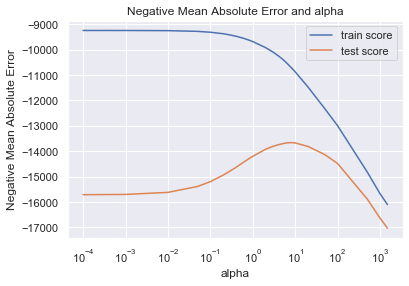

In [93]:
# Plot the alpha and the Negative Mean Absolute Error score for the mean train and test score comparisons
# Visualise the observe how train and test Negative Mean Absolute Error score vary and strong indicator of good model
gridsearch_cv_model_results['param_alpha'] = gridsearch_cv_model_results['param_alpha'].astype('float32')
plt.plot(gridsearch_cv_model_results['param_alpha'], gridsearch_cv_model_results['mean_train_score'])
plt.plot(gridsearch_cv_model_results['param_alpha'], gridsearch_cv_model_results['mean_test_score'])
plt.legend(['train score', 'test score'], loc='best')
plt.xlabel('alpha')
plt.ylabel('Negative Mean Absolute Error')
plt.title("Negative Mean Absolute Error and alpha")
plt.xscale('log')
plt.show()

In [94]:
# Creating a Ridge model object and then using optimal alpha value of 6 fit it with X_train & y_train
# Next we calculate the R2 score of this first basic model on the training set by using predict function
# Next we calculate the R2 score of this first basic model on the test set by using predict function
# We observe that it seems as a decent model with r2 score of 0.88 on unseen test data using ridge Regression
print('Best alpha value obtained in ridge regression after cross validation:', gridsearch_cv_model.best_params_)
ridge_model = Ridge(alpha=8)
ridge_model.fit(X_train, y_train)

y_train_pred = ridge_model.predict(X_train)
print("R2 for Ridge Model on training set:\t", r2_score(y_true=y_train, y_pred=y_train_pred))

y_test_pred = ridge_model.predict(X_test)
print("R2 for Ridge Model on test set:\t\t", r2_score(y_true=y_test, y_pred=y_test_pred))

Best alpha value obtained in ridge regression after cross validation: {'alpha': 8.0}
R2 for Ridge Model on training set:	 0.9388006509940007
R2 for Ridge Model on test set:		 0.9180081572031796


In [95]:
# Find out the ridge model feature parameters
ridge_model_features = list(ridge_model.coef_)
ridge_model_features.insert(0, ridge_model.intercept_)
ridge_model_features = [round(x, 2) for x in ridge_model_features]
ridge_model_cols = X_train.columns
ridge_model_cols = ridge_model_cols.insert(0, "constant")
list(zip(ridge_model_cols, ridge_model_features))

[('constant', 351045.8),
 ('MSSubClass', -117.3),
 ('LotArea', 1.12),
 ('OverallQual', 8223.42),
 ('OverallCond', 5005.09),
 ('MasVnrArea', 4.86),
 ('BsmtFinSF1', 21.91),
 ('BsmtFinSF2', 5.07),
 ('BsmtUnfSF', 1.13),
 ('TotalBsmtSF', 28.11),
 ('1stFlrSF', 32.53),
 ('2ndFlrSF', 51.8),
 ('LowQualFinSF', -70.68),
 ('GrLivArea', 13.65),
 ('BsmtFullBath', 829.95),
 ('BsmtHalfBath', 0.0),
 ('FullBath', 683.97),
 ('HalfBath', -1056.86),
 ('BedroomAbvGr', -2054.74),
 ('KitchenAbvGr', 0.0),
 ('TotRmsAbvGrd', -802.61),
 ('Fireplaces', 3765.03),
 ('GarageCars', 4381.98),
 ('GarageArea', 16.5),
 ('WoodDeckSF', 22.13),
 ('OpenPorchSF', 31.41),
 ('EnclosedPorch', 16.92),
 ('3SsnPorch', -501.83),
 ('ScreenPorch', 35.47),
 ('PoolArea', 0.0),
 ('MiscVal', 2.58),
 ('MoSold', 406.19),
 ('YrSold', -188.26),
 ('DiffYearBuilt', -324.39),
 ('DiffYearRemodAdd', -195.25),
 ('DiffGarageYrBlt', 64.34),
 ('MSZoning_FV', 6116.42),
 ('MSZoning_RH', 888.32),
 ('MSZoning_RL', 1439.07),
 ('MSZoning_RM', -3014.35),
 ('S

In [96]:
# Find all the top features obtained from the Ridge regression model
# So we observe that Ridge regression chooses 123 features
# List of top features obtained from the Ridge regression
parameter_df = pd.DataFrame()
parameter_df = pd.Series(ridge_model_cols).to_frame()
parameter_df.columns = ['Features']
parameter_df['weight'] = pd.Series(ridge_model_features)
print('Number of features selected by Ridge regression:', parameter_df.shape[0])
parameter_df.sort_values(by='weight', ascending=False).head()

Number of features selected by Ridge regression: 227


Features     weight
0                constant  351045.80
59   Neighborhood_Crawfor   14492.36
196        Functional_Typ   12895.33
69   Neighborhood_NridgHt   11505.37
3             OverallQual    8223.42

## Step 7: Overall Evaluation & Inference

- Overall we got six models i.e. three models each from two approaches and all of them seem to be decent models.
- Below is the table which shows r2 score of each model and the optimal alpha value for ridge and lasso regression.
- We observe that Lasso Model 5 regression seems to be the best one taking into account the r2 score and model complexity.
- Optimum value for lambda in lasso regression for Model 5 is 50 and number of relevant features are 118
- Optimum value for lambda in ridge regression for Model 6 is 8 and number of relevant features are 227

| Model No. | Model | train r2_score | test r2 score | optimal alpha | no.of features
| --- | --- | --- | --- | --- | --- |
Model 1 | MLR | 0.913 | 0.871 | NA | 103
Model 2 | Lasso | 0.906 | 0.884 | 0.0001 | 84
Model 3 | Ridge | 0.903 | 0.887 | 4.0 | 227
Model 4 | MLR | 0.949 | 0.908 | NA |203
Model 5 | Lasso | 0.941 | 0.920 | 50 | 118
Model 6 | Ridge | 0.939 | 0.918 | 8.0| 227

In [97]:
# Display the full paramater feature list for Lasso regression model
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(parameter_df_lasso)

                  Features      weight
0                 constant  311038.972
59    Neighborhood_Crawfor   25970.773
196         Functional_Typ   15438.983
69    Neighborhood_NridgHt   15137.152
68    Neighborhood_NoRidge   12626.638
205          GarageQual_Gd   12051.935
75    Neighborhood_StoneBr   10651.345
117    Exterior1st_BrkFace    9644.311
226  SaleCondition_Partial    9478.610
163        BsmtExposure_Gd    8632.724
44         LandContour_HLS    8565.207
56    Neighborhood_BrkSide    7722.449
3              OverallQual    7493.074
36             MSZoning_FV    7202.805
79         Condition1_Norm    7121.870
48       LotConfig_CulDSac    6442.582
214           SaleType_CWD    6114.813
55     Neighborhood_BrDale    5513.744
224   SaleCondition_Family    5253.496
146       MasVnrType_Stone    5125.601
4              OverallCond    4986.174
74    Neighborhood_Somerst    4740.396
142    Exterior2nd_Wd Sdng    4550.311
81         Condition1_PosN    4504.826
22              GarageCar

### Top Features affecting House Prices - Based on Lasso Regression Model

#### Positive relation with the SalePrice
1. Neighborhood: Houses near Crawford, Northridge Heights, Northridge and Stone Brook area are expensive
2. Functional: Homes with typical functionality are high in prices
3. GarageQual: Garage quality as good fetches more saleprice
4. Exterior1st: Brick face exterior covering on house shoots the price also
5. SaleCondition: New homes are costly.

#### Negative relation with the SalePrice
1. SaleCondition_Alloca: Two linked properties with separate deeds, typically condo with a garage unit
2. Functional_Mod: Moderate Deductions
3. KitchenQual: Average kitchen quality
4. Condition1_RRAe: Adjacent to East-West Railroad
5. BsmtQual_Gd: Average basement quality.